# Natural Language Processing Capstone -- Kristofer Schobert

## Implementing NLP Methods to cluster and classify speeches by U.S. president

#### Introduction
As long as their have been organized societies, there have been leaders whose words are heard by the masses and steer the trajectory of their followers. Each leader has their own voice, a unique flavor of their native language, which reflects the times they live in, the audiences listening, and their own personality. With the advent of Natural Language Processing, we can now analyze their words in new, exciting ways. We are able to quanify their speeches, allowing us to find features which distinguish one individual from another. This analysis gives us a better understanding of each of them and helps us predict how they will lead in the future.  

#### Our Task
Using a corpus of U.S. presidential speeches, we will attempt to cluster speeches by the president who gave them. After determining our optimal clustering algorithm, we will compare it to supervised learning classifiers. The data we will be using was curated by D. W. Brown who has collected hundreds of speeches by several U.S. presidents and made them available online at: http://www.thegrammarlab.com/?nor-portfolio=corpus-of-presidential-speeches-cops-and-a-clintontrump-corpus.

#### Our Methodology
We will use speeches from ten different presidents who served during various periods of the nation's history, and divide the speeches into a training and testing data set. To determine the best document-term matrix for clustering by president, we will try different sets of features generated from Bag of Words as well as tf-idf. We will evaluate these document-term matrices after applying k-means clustering using the Adjusted Rand Index (ARI) as our scoring metric. After determining our best document-term matrix, we will try various clustering algorithms to see which is best at clustering our training data by president. Once the best combination of document-term matrix and clustering algorithm is determined we will cluster and evaluate the result our testing data. Next, we will impliment several supervised learning classifiers and see how well we can classify our data. After determining the best classifier, we will use the model to predict our testing data. Finally, we will compare our best clustering algorithm and best classifier via its performance on the data as a whole. 

In [1290]:
# Importing packages

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from collections import Counter
import nltk
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans, KMeans, MeanShift
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import estimate_bandwidth, SpectralClustering, AffinityPropagation
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import time
sns.set_style("white")
nlp = spacy.load('en')

## Data Preparation 

Let's load in our presidents' speeches, each of which is a text file. We will look to see if we have a significant class imbalance. (i.e. Do some presidents have far more speeches in our corpus than others?) We will also clean each text file and convert it to a spaCy document. Once our text files are converted to spaCy docs, we may ask more questions of our data. For example, we can determine each words lemma and part of speech.

In [2]:
# Importing the files from the database that we will analyze. 

# Barack Obama
# 2009 - 2017
obama_files = []
for filename in glob.glob('Corpus_of_Presential_Speeches/obama/*.txt'): 
    file = open(filename, 'r')
    obama_files.append(file.read())
    file.close() 

# G. W. Bush    
# 2001 - 2009
gwbush_files = []    
for filename in glob.glob('Corpus_of_Presential_Speeches/gwbush/*.txt'): 
    file = open(filename, 'r')
    gwbush_files.append(file.read())
    file.close() 

# Bill Clinton    
# 1993 - 2001
clinton_files = []   
for filename in glob.glob('Corpus_of_Presential_Speeches/clinton/*.txt'): 
    file = open(filename, 'r')
    clinton_files.append(file.read())
    file.close()     

# J. F. Kennedy    
# 1961 - 1963
kennedy_files = []
for filename in glob.glob('Corpus_of_Presential_Speeches/kennedy/*.txt'): 
    file = open(filename, 'r')
    kennedy_files.append(file.read())
    file.close()  

# F. D. Roosevelt    
# 1933 - 1945   
fdroosevelt_files = []    
for filename in glob.glob('Corpus_of_Presential_Speeches/fdroosevelt/*.txt'): 
    file = open(filename, 'r')
    fdroosevelt_files.append(file.read())
    file.close() 

# Ulysses S. Grant    
# 1869 - 1877
grant_files = []
for filename in glob.glob('Corpus_of_Presential_Speeches/grant/*.txt'): 
    file = open(filename, 'r')
    grant_files.append(file.read())
    file.close()     

# Andrew Johnson    
# 1865 - 1869    
johnson_files = []
for filename in glob.glob('Corpus_of_Presential_Speeches/johnson/*.txt'): 
    file = open(filename, 'r')
    johnson_files.append(file.read())
    file.close()


# Andrew Jackson    
# 1829 - 1837
jackson_files = []
for filename in glob.glob('Corpus_of_Presential_Speeches/jackson/*.txt'): 
    file = open(filename, 'r')
    jackson_files.append(file.read())
    file.close()     

# Thomas Jefferson    
# 1801 - 1809    
jefferson_files = []
for filename in glob.glob('Corpus_of_Presential_Speeches/jefferson/*.txt'): 
    file = open(filename, 'r')
    jefferson_files.append(file.read())
    file.close() 

# George Washington    
# 1789 - 1797
washington_files = []   
for filename in glob.glob('Corpus_of_Presential_Speeches/washington/*.txt'): 
    file = open(filename, 'r')
    washington_files.append(file.read())
    file.close() 

Let's look to see if certain presidents have more speeches in our corpus than others. 

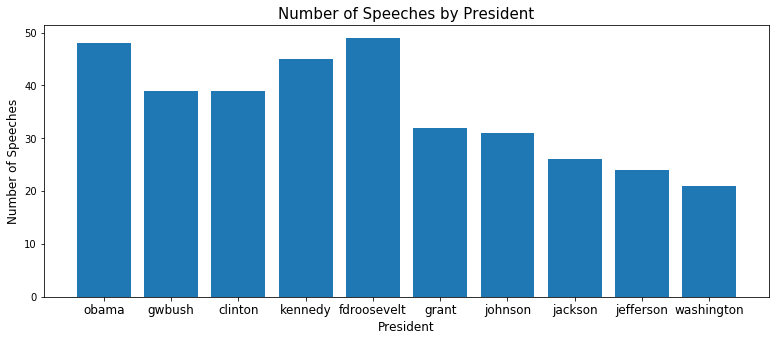

Exact Number of Speeches by President
48 obama
39 gwbush
39 clinton
45 kennedy
49 fdroosevelt
32 grant
31 johnson
26 jackson
24 jefferson
21 washington

Total Number of Speeches: 354


In [102]:
# creating a dictionary of presidents in this order
pres_dict = {0:'obama',
             1:'gwbush',
             2:'clinton', 
             3:'kennedy',
             4:'fdroosevelt',
             5:'grant',
             6:'johnson',
             7:'jackson',
             8:'jefferson',
             9:'washington'}

# creating a list of president names in this order
presidents = list(pres_dict.values())

# creating a list where each element is a list of a president's files.
all_uncleaned_files_by_president = [obama_files, gwbush_files, clinton_files, 
                          kennedy_files, fdroosevelt_files,
                          grant_files, johnson_files, jackson_files, jefferson_files,
                          washington_files]

# looping through each president to get a list of the number of speeches per president
number_of_speeches_list = [len(all_uncleaned_files_by_president[president_number])
             for president_number in range(len(all_uncleaned_files_by_president))]

plt.figure(figsize = (13,5))
plt.bar(height = number_of_speeches_list, x = presidents)
plt.title('Number of Speeches by President', fontsize = 15)
plt.ylabel('Number of Speeches', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

print('Exact Number of Speeches by President')
for index, president in enumerate(presidents):
    print(number_of_speeches_list[index], presidents[index])
    
print('\nTotal Number of Speeches: {}'.format(np.sum(number_of_speeches_list)))    


Our class imbalance is not very significant. The president with the least number of speeches, Washington, has a little less than half of the number of speeches given by F. D. Roosevelt, the president with the greatest number of speeches. This group of presidents also span a wide range of time periods - five presidents before 1900 and five after.

One might be curious to know the total number of words spoken by each president in our corpus. Perhaps a certain president gave more short speeches, while another predominantly gave speeches containing several words. Before we do this, we should split the data into testing and training data. We do not want to learn anything about our hold out testing data. Seeing that some presidents have fewer words than others in both our training and testing data would bias our modeling. 

Let's clean the data.

The curator of this data has done us a huge favor. The titles of the speeches and any words spoken by anyone other than the president are tagged between '<' and '>'. For instance, we have many instances of '< applause >' and plenty of words spoken by an audience member or other politicians tagged between '<' and '>'. We will thus remove any text between those markers.

After cleaning, we will convert each cleaned text file to a spaCy doc.

In [103]:
# cleaning and rewriting files
# we are going to remove anything within < >

def text_cleaner(text):
    
    '''
    This function takes a string of text as its input 

    It returns that same string but with instance of '--' removed 
    and with texts enclosed by '<' and '>' removed.
    '''
    
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[<].*?[>]", "", text)
    text = ' '.join(text.split())
    return text


# looping through each file and applying the text_cleaner function
all_cleaned_files_by_president = []
for index, president_files in enumerate(all_uncleaned_files_by_president):
    all_cleaned_files_for_this_president = []
    all_cleaned_files_by_president.append(all_cleaned_files_for_this_president)
    for file in president_files:
        all_cleaned_files_for_this_president.append(text_cleaner(file))

# renaming all_cleaned_files_by_president simply all_files_by_president
all_files_by_president = all_cleaned_files_by_president        
  

# looping through each cleaned file and converting it to a spacy doc.  
all_docs_by_president = []
for index, president_file in enumerate(all_files_by_president):
    all_docs_for_this_president = []
    all_docs_by_president.append(all_docs_for_this_president)
    for file in president_file:
        all_docs_for_this_president.append(nlp(file))
    print('converted the {} files to docs'.format(pres_dict[index]))      

converted the obama files to docs
converted the gwbush files to docs
converted the clinton files to docs
converted the kennedy files to docs
converted the fdroosevelt files to docs
converted the grant files to docs
converted the johnson files to docs
converted the jackson files to docs
converted the jefferson files to docs
converted the washington files to docs


We will now create a pandas dataframe with our text files, spaCy docs, and their cooresponding presidents. We will split the speeches into training and testing data, using a 75:25 ratio. This spliting will be stratified such that 25% of *each president's* speeches are used as testing data.

In [70]:
# creating a list where each element is a list of two elements, 
# a spaCy doc and the cooresponding president
list_of_doc_comma_pres = []
for president_number in range(len(all_docs_by_president)):
    list_of_doc_comma_pres.extend([[doc,pres_dict[president_number]] 
                                   for doc in all_docs_by_president[president_number]])
    
# creating a list where each element is a list of two elements, 
# a speech expressed as a string and the cooresponding president    
list_of_file_comma_pres = []
for president_number in range(len(all_files_by_president)):
    list_of_file_comma_pres.extend([[file,pres_dict[president_number]] 
                                   for file in all_files_by_president[president_number]])
    

# converting those lists into an array    
array_of_doc_comma_pres = np.array(list_of_doc_comma_pres)
array_of_file_comma_pres = np.array(list_of_file_comma_pres)

# creating a pandas dataframe with this data
df_main = pd.DataFrame(array_of_doc_comma_pres)
df_main[2] = array_of_file_comma_pres[:,0]
df_main = df_main.rename(columns={0:"doc_", 2:"text_", 1:"president_"})
df_main.head()

# splitting the data into training and testing data. We will use a 75-25 split. 
# we have stratified the splitting with respect to the presidents
# i.e. 25% of each presidents speeches are used as testing data. 
X_train, X_test, y_train, y_test = train_test_split(df_main[['doc_', 'text_']], 
                                                    df_main['president_'],
                                                    test_size=0.25,
                                                    random_state=3, 
                                                    stratify=df_main['president_'])

# creating new pandas data frames. one for training and one for testing.
df_train = pd.DataFrame()
df_train[['doc_', 'text_']] = X_train
df_train['president_'] = y_train
df_train = df_train.reset_index().copy()
df_train = df_train.drop('index', 1)

df_test = pd.DataFrame()
df_test[['doc_', 'text_']] = X_test
df_test['president_'] = y_test
df_test = df_test.reset_index().copy()
df_test = df_test.drop('index', 1)

In [1153]:
print('Our training data contains {} speechs, '.format(len(df_train)) + 
      'and our testing data contains {} speeches.'.format(len(df_test)))
print('The first five rows of df_train:')
df_train.head()


Our training data contains 265 speechs, and our testing data contains 89 speeches.
The first five rows of df_train:


,doc_,text_,president_
0,"(To, the, House, of, Representatives, :, I, ha...",To the House of Representatives: I have given ...,grant
1,"(Fellow, -, Citizens, of, the, Senate, and, Ho...",Fellow-Citizens of the Senate and House of Rep...,johnson
2,"(Vice, President, Johnson, ,, Mr., Speaker, ,,...","Vice President Johnson, Mr. Speaker, Mr. Chief...",kennedy
3,"(Whereas, it, is, the, duty, of, all, Nations,...",Whereas it is the duty of all Nations to ackno...,washington
4,"(To, the, House, of, Representatives, :, I, ha...",To the House of Representatives: I have consid...,johnson


Now we may look to see the word count of each president in our training data. Let's also find the average number of words by speech per president. 

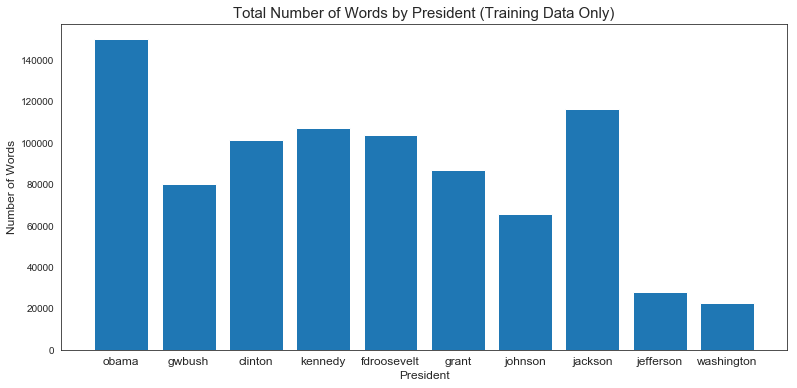

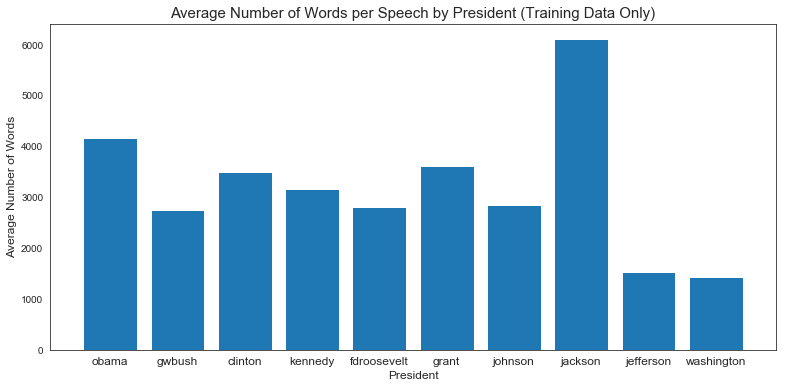

In [1314]:
# Creating a list of all the total number of words per president
president_word_counts = []
for president in presidents:
    president_word_count = 0
    for doc in df_train[df_train['president_'] == president]['doc_']:
        for token in doc:
            if not token.is_punct:  # not counting punctuation as a word
                president_word_count += 1
    president_word_counts.append(president_word_count)  

president_speech_counts = []
for president in presidents:
    president_speech_counts.append(len(df_train[df_train['president_'] == president]))

average_words_per_speech = np.divide(president_word_counts, president_speech_counts)    

# plotting our results
sns.set_palette('tab10')
plt.figure(figsize = (13,6))
plt.bar(height = president_word_counts, x = presidents)
plt.title('Total Number of Words by President (Training Data Only)', fontsize = 15)
plt.ylabel('Number of Words', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

plt.figure(figsize = (13,6))
plt.bar(height = average_words_per_speech, x = presidents)
plt.title('Average Number of Words per Speech by President (Training Data Only)', fontsize = 15)
plt.ylabel('Average Number of Words', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()


Well, we have some more serious imbalance in terms of total words per president. We do not have as much training data from Jefferson and Washington, but we want to represent this early period in U.S. history. Thus, we will continue with these ten presidents. At least, there is not as much of an imbalance when considering the number of speeches by president, which is what we are attempting to cluster. 

It is worth noting that the total word count imbalance between Obama and Washington is amplified because Obama has more speeches with more average words per speech than Washington. Also, Andrew Jackson has the highest average word count per speech. We could use this information in our clustering and modeling by making word count per speech a feature. 

One may wonder if this is truly representative of George Washington's speeches. Were they usually that much shorter than present-day speeches? The database may be bias by simply not have some of his longer speeches. Or maybe we do have some of his longer speeches and they are in the hold out group. In any case, it is informative to be aware of the differing amounts of data in our classes. 

# Clustering our Data

## Bag of Words

We will now begin clustering our data. Our first model will be a Bag of Words model, where we count the number of instances of certain words per document. We will use the 50 most common words spoken by each president as our features of this document-term matrix. Note that we will be using the lemmas of words throughout this process. 

We first must join each president's spaCy docs together, giving us one spaCy doc per president. 

In [104]:
# joining the strings of each president's speeches together
president_files_joined = []
for n in range(len(presidents)): 
    president_files_joined.append(' '.join(
        df_train[df_train['president_'] == presidents[n]]['text_']))

# converting the joined strings to spaCy docs
# (it seems there is no straightforward way of joining spaCy docs together)
president_docs_joined = [] 
for index, president_file_joined in enumerate(president_files_joined):
    president_docs_joined.append(nlp(president_file_joined))
    print('converted the joined {} file to a spaCy doc'.format(presidents[index])) 

converted the joined obama file to a spaCy doc
converted the joined gwbush file to a spaCy doc
converted the joined clinton file to a spaCy doc
converted the joined kennedy file to a spaCy doc
converted the joined fdroosevelt file to a spaCy doc
converted the joined grant file to a spaCy doc
converted the joined johnson file to a spaCy doc
converted the joined jackson file to a spaCy doc
converted the joined jefferson file to a spaCy doc
converted the joined washington file to a spaCy doc


## 50 Most Common Words per President

In [105]:
def bag_of_words(doc, number_of_words_per_president):
    
    '''
    Function to create a list of the most common words spoken by each president.

    We input a spaCy doc of the joined speeches for a president and 
    the number of most common words we seek to determine.

    '''
    
    # Loop through each doc and filter out punctuation and stop words.
    # we will collect the most common words from each doc.
    
    allwords = []
    for token in doc:
        if not token.is_punct and not token.is_stop:
                allwords.append(token.lemma_)

    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(
        number_of_words_per_president)]
            
# creating a list of all presidents most common words
# the length of this list will be number_of_words_per_president * 10
# because we have 10 presidents
list_of_all_presidents_most_common_words = []
for n in range(len(presidents)):
    list_of_all_presidents_most_common_words.extend(
        bag_of_words(president_docs_joined[n], 50))

# Creating our list of features
# This is the set of the most common words of all the presidents
# list_of_all_presidents_most_common_words has duplicate words 
# since some words are common in multiple presidents
common_words = list(set(list_of_all_presidents_most_common_words))
print('We have a total of {} most common words \
for all the presidents.'.format(len(common_words)))

We have a total of 190 most common words for all the presidents.


After searching through our speeches and finding the 50 most common words for each president, we find that there are 190 unique words in that set of 500 words. To be clear, we have 500 total words because we found the 50 most common words for each of the 10 presidents. However, many of those words are duplicates since some words are common to multiple presidents.

In [106]:

def bow_features(df_init, common_words):
    
    '''
    This function takes in our original data frame of spaCy docs, 
    text files and cooresponding presidents along with a list 
    of the most common words to concider.

    It returns our desired Bag of Words document-term matrix.

    '''
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['doc_'] = df_init.loc[:, 'doc_']
    df['text_'] = df_init.loc[:, 'text_']
    df['president_'] = df_init.loc[:, 'president_']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, doc in enumerate(df['doc_']):

        # Convert the paragraphs to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = []
        for token in doc:
            lemma = token.lemma_
            if lemma in common_words:
                words.append(lemma)
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 10 == 0:
            print("Processing row {}".format(i))
            
    return df

In [109]:
# Creating the document-term matrix 
# This process can take some time.
# We will record how many seconds it takes. 
start = time.time()
df_bow_50 = bow_features(df_train, common_words)
end = time.time()
print(end - start)

Processing row 0
Processing row 10
Processing row 20
Processing row 30
Processing row 40
Processing row 50
Processing row 60
Processing row 70
Processing row 80
Processing row 90
Processing row 100
Processing row 110
Processing row 120
Processing row 130
Processing row 140
Processing row 150
Processing row 160
Processing row 170
Processing row 180
Processing row 190
Processing row 200
Processing row 210
Processing row 220
Processing row 230
Processing row 240
Processing row 250
Processing row 260
202.8977608680725


We now have our desired term-document matrix.

In [110]:
df_bow_50.head()

,support,defense,enemy,world,exist,find,Representatives,view,power,authority,...,particular,effort,Indians,vessel,plan,recommend,new,doc_,text_,president_
0,0,0,0,0,1,2,7,2,13,4,...,1,1,0,0,0,1,0,"(To, the, House, of, Representatives, :, I, ha...",To the House of Representatives: I have given ...,grant
1,6,2,0,7,8,9,5,6,36,10,...,0,1,0,5,1,3,6,"(Fellow, -, Citizens, of, the, Senate, and, Ho...",Fellow-Citizens of the Senate and House of Rep...,johnson
2,4,0,2,8,0,2,0,1,7,0,...,0,2,0,0,1,0,7,"(Vice, President, Johnson, ,, Mr., Speaker, ,,...","Vice President Johnson, Mr. Speaker, Mr. Chief...",kennedy
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,"(Whereas, it, is, the, duty, of, all, Nations,...",Whereas it is the duty of all Nations to ackno...,washington
4,2,0,2,0,2,2,2,0,0,4,...,0,1,0,0,0,0,0,"(To, the, House, of, Representatives, :, I, ha...",To the House of Representatives: I have consid...,johnson


## Using K-Means clustering to analyze our document-term matrix

In [1329]:
def k_means_analysis(X, y_true, n_clusters, params, description):
    
    """ 
    This function takes as inputs the document-term matrix X, the labels y_true, 
    the number of clusters, other k-means parameters and a description of the input 
    martix properties.

    While it does not return anything explicitly, it plots properties of the 
    confusion matrix and makes scatterplots of the true labels and k-means clustering
    labels along the two primary LSA components. It also gives statistics on the ARI, 
    completeness, homogeneity, and v_measure_scores after running the clustering 
    algorithm ten times. Note that the bar plots and scatter plots are of the tenth
    trial used to determine the scoring statistics.

    """
    
    # we will cluster our data ten times and calculate statistics of 
    # our metrics for cluster evaluation.
    number_of_trials = 10
    
    ari_scores = []
    completeness_scores = []
    homogeneity_scores = []
    v_measure_scores = []
    
    for trial in range(number_of_trials):

        # we will use scikit-learns MiniBatchKMeans function
        minibatchkmeans = MiniBatchKMeans(
            **params, n_clusters=n_clusters, random_state=trial)
            # this uses the same 10 different random_states each time the code is run)

        # fitting k-means and predicting on our data
        y_pred = minibatchkmeans.fit_predict(X)
        ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
        completeness_scores.append(metrics.completeness_score(y_true, y_pred))
        homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
        v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

    # we will print our the score after our plots
        
    # calculating the contigency table for our clustering
    # this will be clustering of the last of the trials.
    # we have to choose one of the ten clusterings to evaluate.
    
    contigency_table = pd.crosstab(y_pred, y_true)[presidents]

    # Normalizing the contigency table. 
    # We seek to know the percentage of each presidents speeches in a given cluster.
    contigency_table_normalized = pd.DataFrame(
        normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
    contigency_table_normalized.columns = [presidents]
    
    
    # plotting a very similar graph from the transpose of the contingency matrix
    # normalizing the crosstab scores so that we can see a given cluster's 
    # presidental constituents
    crosstab_normalized_T = pd.DataFrame(
        normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
    crosstab_normalized_T.columns = range(n_clusters)

    
    
    
    # ploting this contigency table as a staked bar plot
    sns.set_palette('tab10')
    ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
    ax3.set(xticklabels = presidents)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title('Fraction of President\'s Speeches in K-Means Clusters\n Using '
              + str(description), fontsize = 12)
    plt.xlabel('President', fontsize = 12)
    plt.ylabel('Fraction', fontsize = 12) 
    plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1),
               prop={'size': 12})
    plt.ylim(0,1)
    plt.show()

    # plotting a presidents cluster breakdown
    sns.set_palette('bright')
    ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
    ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
    plt.xticks(fontsize = 12, rotation='horizontal')
    plt.yticks(fontsize = 12)
    plt.xlabel('Cluster', fontsize = 12)
    plt.ylabel('Fraction', fontsize = 12) 
    plt.legend(presidents, title = 'President', title_fontsize = 12,
               bbox_to_anchor=(1, 1), prop={'size': 12})
    plt.ylim(0,1)
    plt.title('The Relative Constituents of Each K-Means Cluster\n Using '
              + str(description), fontsize = 12)
    plt.show()

    
    # making a two scatter plots of the clusters labeled by predicted cluster 
    # and true class. We will plot their projection onto the two primary 
    # LSA components.
    
    # creating a data frame with the two LSA components
    lsa2 = TruncatedSVD(n_components=2)
    X_lsa2 = lsa2.fit_transform(X)
    df_lsa2 = pd.DataFrame(X_lsa2)
    df_lsa2['y_true'] = y_true
    df_lsa2['y_pred'] = y_pred
    df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

    # plotting the speech along the 2 principal compontents of LSA 
    # (Latent Semantic Analysis) 
    plt.figure(figsize=(13,6))
    sns.set_palette('tab10')    
    plt.subplot(1, 2, 1)
    plt.title('K-Means Clusters Projected onto LSA Components\nUsing '
              + str(description), fontsize = 12)
    ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                          palette=['C0', 'C1', 'C2','C3','C4','C5',
                                   'C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
    legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
    legend.texts[0].set_text("Cluster")
    plt.xlabel('LSA Component 0')
    plt.ylabel('LSA Component 1')
    
    plt.subplot(1, 2, 2)
    plt.title('Speeches by President Projected onto LSA Components\nUsing '
              + str(description), fontsize = 12)
    ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents,
                          palette = 'bright', data = df_lsa2)
    legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
    legend.texts[0].set_text("President")
    plt.xlabel('LSA Component 0')
    plt.ylabel('LSA Component 1')
    plt.show()

    print('Using {}'.format(description))    
    print('ARI score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(ari_scores), 3),
        round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
    print('completeness score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(completeness_scores), 3),
        round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
    print('homogeneity score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(homogeneity_scores), 3),
        round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
    print('v-measure score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(v_measure_scores), 3), 
        round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

In [1330]:
################################################################################
def k_means_scores(X, y_true, n_clusters, params, description):
    
    """ 
    This function takes as inputs the document-term matrix X, the labels y_true, 
    the number of cluster, other parameters and a description of the input martix 
    properties.

    While it does not return anything explicitly, it gives statistics on the ARi, 
    completeness, homogeneity, and v_measure_scores after running the clustering 
    algorithm ten times. 

    """
    
    # we will cluster our data ten times and calculate statistics of our metrics 
    # for cluster evaluation.
    number_of_trials = 10
    
    ari_scores = []
    completeness_scores = []
    homogeneity_scores = []
    v_measure_scores = []
    
    for trial in range(number_of_trials):

        # we will use scikit-learns MiniBatchKMeans function
        minibatchkmeans = MiniBatchKMeans(**params, n_clusters=n_clusters,
                                          random_state=trial)
        # this uses the same 10 different random_states each time the code is run)

        # fitting k-means and predicting on our data
        y_pred = minibatchkmeans.fit_predict(X)
        ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
        completeness_scores.append(metrics.completeness_score(y_true, y_pred))
        homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
        v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

    print('Using {}'.format(description))    
    print('ARI score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(ari_scores), 3),
        round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
    print('completeness score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(completeness_scores), 3),
        round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
    print('homogeneity score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(homogeneity_scores), 3),
        round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
    print('v-measure score: {:.3f} +/- {:.3f}'.format(
        round(np.mean(v_measure_scores), 3),
        round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

### Using K-means to cluster our document-term matrix: df_bow_50

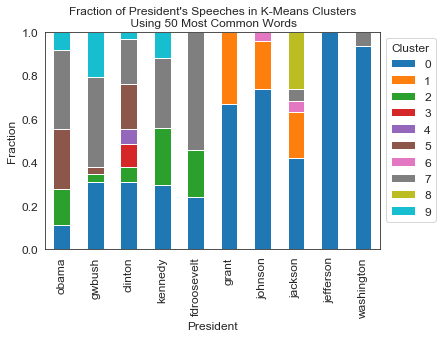

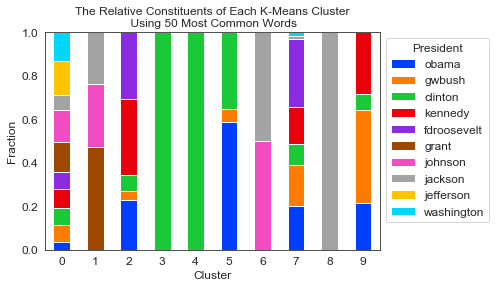

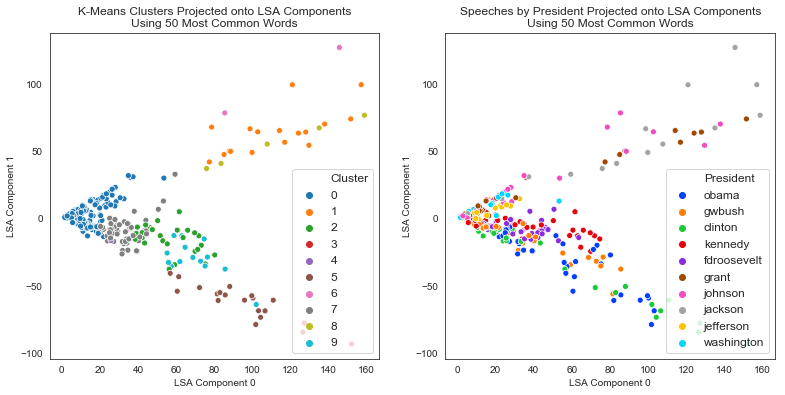

Using 50 Most Common Words
ARI score: 0.062 +/- 0.017
completeness score: 0.363 +/- 0.014
homogeneity score: 0.252 +/- 0.013
v-measure score: 0.298 +/- 0.013


In [1021]:
X_bow_50 = np.array(df_bow_50.drop(['doc_', 'text_', 'president_'], 1))
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

Let's discuss what these plots show. 

The two bar plots visualize information in a contingency table. The first bar plot, titled "Fraction of President's Speeches by K-Means Cluster," reflects our model's completeness score. This plot informs us on how well each president's speeches are clustered into the same cluster. If each bar is one solid color, we would have a completeness score of 1.0 because, for each president, all their speeches would be clustered into the same cluster. 

This second bar plot, titled "The Relative Constituents of Each K-Means Cluster," reflects our homogeneity score. If each bar is one solid color, we would have a homogeneity score of 1.0 because each cluster would be comprised of only one president's speeches. If we were to achieve the exact clustering we seek, each president would have their own cluster, thus each bar in the first and second barplot would be one unique color. 

The scatter plot on the left shows our model's clusters projected onto the two primary LSA components. They are color coded to match the colors of the first barplot. The scatter plot on the right shows our true labels (a speech's president) and again this data is projected onto the two primary LSA components. The color coding of the second scatter plots matches the color coding of the second bar plot. 

Now, in the model we are currently evaluating, we can see that some of each president's speeches are clustered into Cluster '0', which is colored blue. This is also apparent in second bar plot where we see that Cluster '0' is made of some amount of every president's speeches. Also from the second bar plot, we see that Cluster '3' and '4' are made entirely of Bill Clinton speeches. This is reflected in the first plot. We can see that Clinton is the only president with any red or purple bar segments.

The five most recent presidents have a substantial fraction of their speeches grouped into cluster '7' colored grey and cluster '2' colored green. This is reasuring. We would hope that presidents of similar time periods get grouped together. Political topics and trends in speech should be more similar for presidents of similar times. 

By looking at the scatter plots we can see that some presidents cluster together. Obama, Clinton, G.W.Bush, F.D.Roosevelt, and Kennedy cluster together on the lower leg of the v-shape. Jackson, Johnson, Grant, Washington, and Jefferson cluster together on the upper leg of the v-shape. 

To be transparent, LSA (Latent semantic analysis) is a kind of dimensionality reduction similar to PCA, but used for document-term matrices, where values of that matrix are positive frequency counts rather than some continuous variable. Each LSA component represents a linear combination of words. While each LSA component has some nonzero amount of each word in our Bag of Words, each LSA component aligns more strongly with just a handful of words. A datapoint with a high value for LSA component 0 indicates that that speech contained a lot of the words that make up LSA component 0. A point with a low coefficient for LSA component 0 indicates that that speech did not contain many of the words of that component. 

Now, let's discuss the scoring. We run the clustering algorithm ten times on the input matrix and calculate the mean and twice the standard deviations of the mean to use as our values for the mean score and it's uncertainty. Which of those ten trials is plotted in the four plots? We must choose one, and we have picked the final trial. 

From our Adjusted Rand Index we see that our clustering does a poor job of clustering speeches by president. To obtain this score, one must look at pairs of points (pairs of speeches). We will have a high ARI score if pairs of points that are from the same president are clustered in the same cluster, and if pairs of points that are not from the same president are located in different clusters. Our completeness score gives us a measure of how well a given president's speeches are grouped into the same cluster. Our homogeneity score gives us a measure of how homogeneous our clusters are. The v-measure score is the harmonic mean of our homogeneity score and completeness score.

Let's now try scaling our input matrix.

### df_bow_50 and scaling each feature to have a mean of zero and unit variance

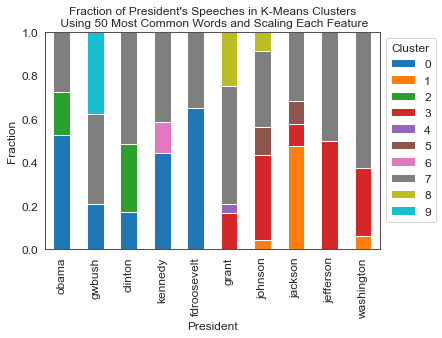

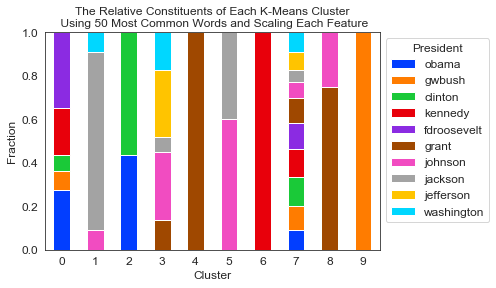

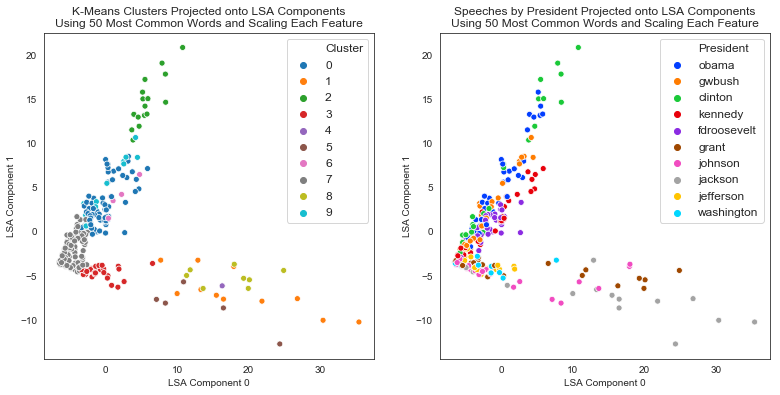

Using 50 Most Common Words and Scaling Each Feature
ARI score: 0.078 +/- 0.021
completeness score: 0.413 +/- 0.020
homogeneity score: 0.285 +/- 0.024
v-measure score: 0.336 +/- 0.021


In [1002]:
X_bow_50 = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 0)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words and Scaling Each Feature'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

This scaling of each feature did help our completness score some, but that is about it. The ARI score's improvment is not statistically significant. The errorbars on those scores are two standard deviations of the mean.

One curious thing is that now our recent presidents are contained in the upper leg in our plot of the LSA projection of our datapoints.

### df_bow_50 scaling each sample to have a mean of zero and unit variance

By doing this, we are helping to treat each document fairly in terms of length. Longer speeches generally have higher common words counts because they contain more words. By scaling the coefficients by document, we weigh long and short speeches more equally. 

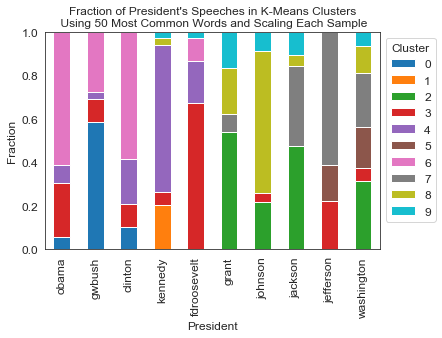

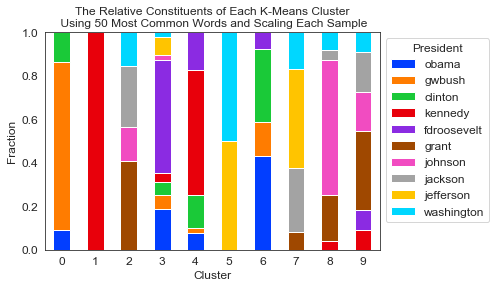

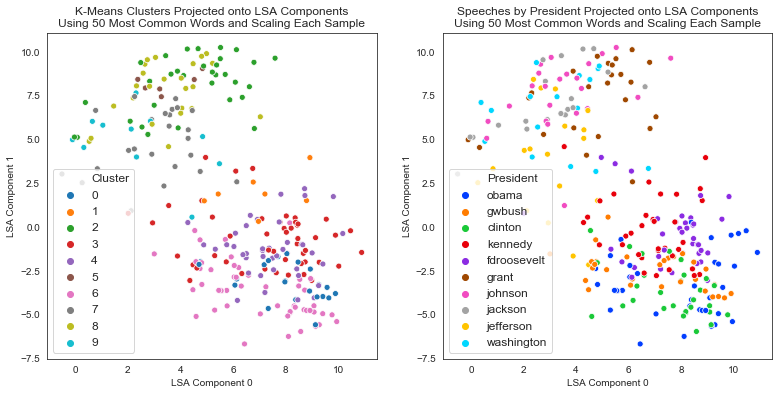

Using 50 Most Common Words and Scaling Each Sample
ARI score: 0.243 +/- 0.015
completeness score: 0.455 +/- 0.017
homogeneity score: 0.437 +/- 0.014
v-measure score: 0.446 +/- 0.015


In [972]:
X_bow_50 = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words and Scaling Each Sample'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

Scaling by sample works much better than scaling by feature. 

If we look at the bar graph we see a clear color scheme for the left five presidents and a different color scheme for the right five presidents.

The v-shaped LSA projection we had seen before is now more of a blob with two areas of more tightly packed datapoints when viewed from these two dimensions. The two densly packed regions seem to cluster the presidents by time period pretty well. Let's investigate this further by seeing how this algorithm clusters our data when creating only 2 clusters. 

### df_bow_50 scaling each sample and grouping into two clusters

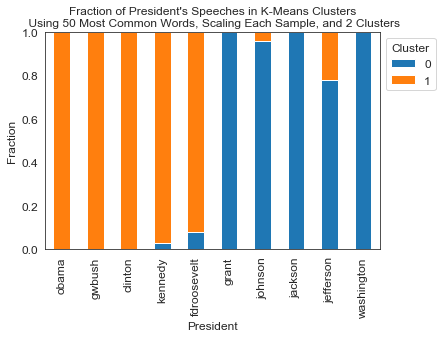

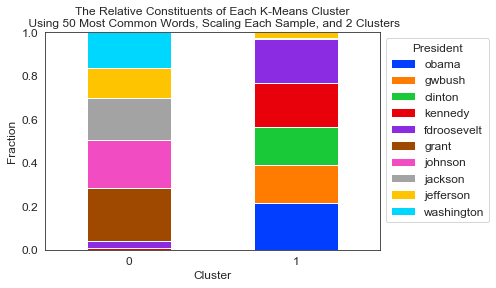

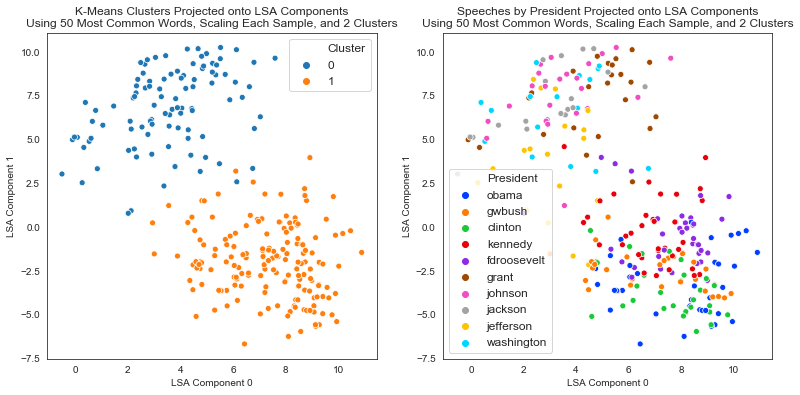

Using 50 Most Common Words, Scaling Each Sample, and 2 Clusters
ARI score: 0.162 +/- 0.001
completeness score: 0.827 +/- 0.008
homogeneity score: 0.241 +/- 0.003
v-measure score: 0.373 +/- 0.004


In [976]:
X_bow_50 = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
y_true = df_bow_50['president_']
n_clusters = 2
params = {}
description = '50 Most Common Words, Scaling Each Sample, and 2 Clusters'
k_means_analysis(X_bow_50, y_true, n_clusters, params, description)

We have clustered the five most recent presidents together and the five least recent presidents together very well here. Our high completeness score indicates this. Also notice that the errors in our evaluation scores are far lower than they were previously. The ARI error (2 standard deviations of the mean) is 0.001. All of the errors in those evaluation metrics are of that order of magnitude. 

Let's try applying LSA to the document-term matrix.

### df_bow_50 using LSA with 5 components scaling by Sample

In [1028]:
X = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=5, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-5'
k_means_scores(X_lsa, y_true, n_clusters, params, description)



Using 50 Most Common Words, Scaling Each Sample, and LSA-5
ARI score: 0.219 +/- 0.010
completeness score: 0.436 +/- 0.010
homogeneity score: 0.432 +/- 0.010
v-measure score: 0.434 +/- 0.010


These scores are slightly worse than the scores earned when not using LSA before clustering. Let's try using 10 components of LSA. Maybe we need more details of our data to cluster well. 

### df_bow_50 using LSA with 10 components scaling by sample

In [1036]:
X = scale(np.array(df_bow_50.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=10, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-10'
k_means_scores(X_lsa, y_true, n_clusters, params, description)


Using 50 Most Common Words, Scaling Each Sample, and LSA-10
ARI score: 0.250 +/- 0.007
completeness score: 0.460 +/- 0.010
homogeneity score: 0.458 +/- 0.009
v-measure score: 0.459 +/- 0.010


This clustering algorithm is the best we have found for achieving our goal. Let's try using more components of LSA and continue to scale by sample. We will use 20 components and also try 100 compontents. With 190 features total, 100 components is still a large amount of dimensionality reduction.

### df_bow_50 using LSA with 20 and 100 components scaling by sample

In [1035]:
X = scale(np.array(df_bow_50.drop(['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=20, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-20'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

print('\n')
X = scale(np.array(df_bow_50.drop(['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=100, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_50['president_']
n_clusters = 10
params = {}
description = '50 Most Common Words, Scaling Each Sample, and LSA-100'
k_means_scores(X_lsa, y_true, n_clusters, params, description)


Using 50 Most Common Words, Scaling Each Sample, and LSA-20
ARI score: 0.254 +/- 0.012
completeness score: 0.460 +/- 0.014
homogeneity score: 0.453 +/- 0.013
v-measure score: 0.457 +/- 0.013


Using 50 Most Common Words, Scaling Each Sample, and LSA-100
ARI score: 0.236 +/- 0.012
completeness score: 0.450 +/- 0.015
homogeneity score: 0.432 +/- 0.012
v-measure score: 0.441 +/- 0.013


While our mean ARI score using 20 components is larger than the mean ARI score with 10, the uncertainly of 0.014 keeps up from making a claim that 20 components is better. Let's leave our winner as is. Also, using 100 LSA components did not help our score. 

### df_bow_50 Conclusion:
When using our presidents' top 50 Bag of Words document-term matrix, our winning clustering algorithm scales by sample, reduces the matrix's demensionality to 10 LSA components and impliments k-means. Here is a summary of the scores it recieved. 

_Using 50 Most Common Words, Scaling Each Sample, and LSA-10_

ARI score: 0.250 +/- 0.007

completeness score: 0.460 +/- 0.010

homogeneity score: 0.458 +/- 0.009

v-measure score: 0.459 +/- 0.010


There are many other combinations we could try with this document_term matrix. We could use a totally different clustering algorithm like Affinity Propagation, we could normalize our matrix in many other ways, we could try other parameters in Scikit-Learns MiniBatchKMeans algorithm - the combinations are endless. For now, let's use a different document term matrix and see how well we can cluster by president. We did not have much luck clustering by the top 50 words from each president, so let's try the top 500 words from each president. 

In [1037]:
# creating a list of all presidents most common words
# the length of this list will be number_of_words_per_president * 10
# because we have 10 presidents
list_of_all_presidents_most_common_words = []
for n in range(len(presidents)):
    list_of_all_presidents_most_common_words.extend(
        bag_of_words(president_docs_joined[n], 500))

# Creating our list of features
# This is the set of the most common words of all the presidents
# list_of_all_presidents_most_common_words has duplicate words 
# since some words are common in multiple presidents
common_words = list(set(list_of_all_presidents_most_common_words))
print('We have a total of {} most common words for all the presidents.'.format(
    len(common_words)))


We have a total of 1560 most common words for all the presidents.


Below we have the code to create this Bag of Words document-term matrix. It takes about one hour to run. I ran it previously and saved the data frame as a csv on my computer. I will just import it back into this Jupyter Notebook. 

The code in the cell below will create the pandas data frame.

In [ ]:
# Creating the document-term matrix 
# This process can take some time.
# We will record how many seconds it takes. 
start = time.time()
df_bow_500 = bow_features(df_train, common_words)
end = time.time()
print(end - start)


In [637]:
# skip this step and use the code below
df_bow_500 = pd.read_csv('df_bow_500_presidents.csv', index_col=0)

In [638]:
df_bow_500.head()

,buy,require,seat,cable,disease,soon,Pacific,review,engage,adopt,...,September,Castro,hear,enemy,instance,homeland,Japanese,doc_,text_,president_
0,0,6,17,0,0,1,0,0,0,0,...,3,0,0,0,1,0,0,To the House of Representatives: I have given ...,To the House of Representatives: I have given ...,grant
1,0,11,0,0,0,1,1,0,2,3,...,0,0,0,0,0,0,0,Fellow-Citizens of the Senate and House of Rep...,Fellow-Citizens of the Senate and House of Rep...,johnson
2,0,1,0,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0,"Vice President Johnson, Mr. Speaker, Mr. Chief...","Vice President Johnson, Mr. Speaker, Mr. Chief...",kennedy
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Whereas it is the duty of all Nations to ackno...,Whereas it is the duty of all Nations to ackno...,washington
4,0,2,0,0,0,1,0,0,2,0,...,0,0,0,2,0,0,0,To the House of Representatives: I have consid...,To the House of Representatives: I have consid...,johnson


Let's see what combonation of scaling and LSA is best for this document-term matrix. Again, we will stick to using k-means for now. When we have found the document-term matrix that is best for the basic k-means clustering, we will see how it performs with other clustering algorithms.  

### Top 500 Bag of Words document-term matrix (df_bow_500) using k-means with no scaling

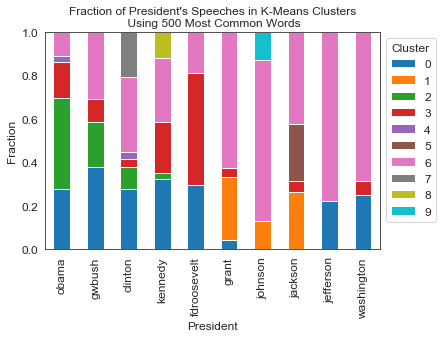

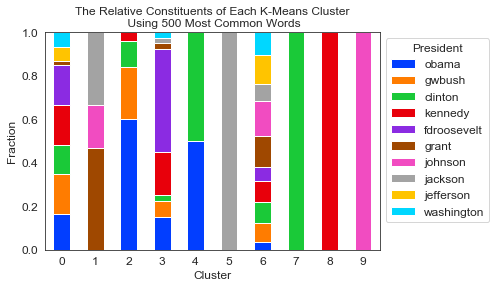

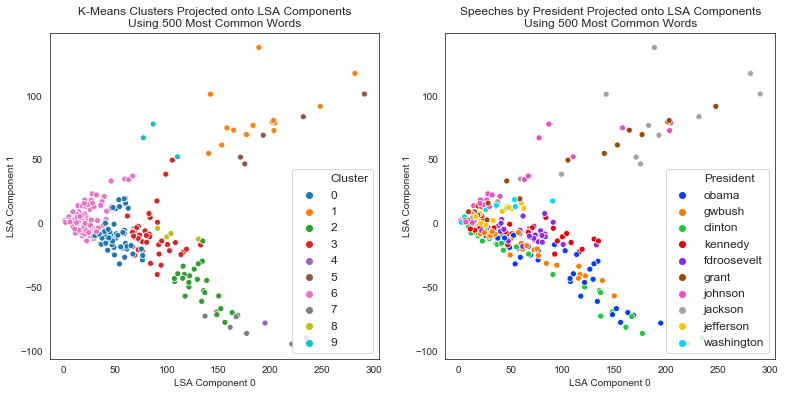

Using 500 Most Common Words
ARI score: 0.049 +/- 0.010
completeness score: 0.304 +/- 0.010
homogeneity score: 0.218 +/- 0.013
v-measure score: 0.253 +/- 0.011


In [1038]:
X_bow_500 = np.array(df_bow_500.drop(['doc_', 'text_', 'president_'], 1))
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words'
k_means_analysis(X_bow_500, y_true, n_clusters, params, description)

Well that did not perform well at all. It's ARI score is even worse than using not scaling with only our Top 50 Bag of Words matrix. Let's try scaling by feature, then scaling by sample.

### df_bow_500 scaling by feature

In [1331]:
X_bow_500 = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 0)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling by Feature'
k_means_scores(X_bow_500, y_true, n_clusters, params, description)

Using 500 Most Common Words, Scaling by Feature
ARI score: 0.042 +/- 0.017
completeness score: 0.385 +/- 0.025
homogeneity score: 0.192 +/- 0.019
v-measure score: 0.253 +/- 0.015


That is even worse than with out scaling. Now let's scale by sample.

### df_bow_500 scaling by sample

In [1332]:
X_bow_500 = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling by Sample'
k_means_scores(X_bow_500, y_true, n_clusters, params, description)

Using 500 Most Common Words, Scaling by Sample
ARI score: 0.257 +/- 0.025
completeness score: 0.486 +/- 0.020
homogeneity score: 0.437 +/- 0.022
v-measure score: 0.460 +/- 0.020


Once again, scaling by sample leads to the best scores. This algorithm's ARI score is roughly equal the best df_bow_50 algorithm's ARI score. Let's apply LSA after scaling and see if our model benefits. 

### df_bow_500 scaling by sample using LSA with 5 components

In [1043]:
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=5, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-5'
k_means_scores(X_lsa, y_true, n_clusters, params, description)


Using 500 Most Common Words, Scaling Each Sample, and LSA-5
ARI score: 0.190 +/- 0.006
completeness score: 0.401 +/- 0.004
homogeneity score: 0.394 +/- 0.004
v-measure score: 0.398 +/- 0.004


This performed worse. Let's try 10 components of LSA.

### df_bow_500 scaling by sample using LSA with 10 components

In [1047]:
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=10, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-10'
k_means_scores(X_lsa, y_true, n_clusters, params, description)


Using 500 Most Common Words, Scaling Each Sample, and LSA-10
ARI score: 0.258 +/- 0.024
completeness score: 0.442 +/- 0.018
homogeneity score: 0.439 +/- 0.019
v-measure score: 0.440 +/- 0.018


This ARI score is not significantly better than our df_bow_500 without LSA ARI score. Also, this v-measure score is worse than our df_bow_500 without LSA v-measure score. Thus, not using LSA is still yields our best model. Let's try 20 LSA components.

### df_bow_500 scaling by sample using LSA with 20 components

In [1048]:
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=20, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-20'
k_means_scores(X_lsa, y_true, n_clusters, params, description)


Using 500 Most Common Words, Scaling Each Sample, and LSA-20
ARI score: 0.283 +/- 0.023
completeness score: 0.469 +/- 0.015
homogeneity score: 0.465 +/- 0.016
v-measure score: 0.467 +/- 0.016


We have found our new champion. Using df_bow_500, scaling by sample, and using 20 LSA components yields the highest ARI score we have seen. Let's see if more LSA components increases our ARI score. 

### df_bow_500 scaling by sample using LSA with 30 components

In [1049]:
X = scale(np.array(df_bow_500.drop(['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
lsa = TruncatedSVD(n_components=30, random_state=0)
X_lsa = lsa.fit_transform(X)
y_true = df_bow_500['president_']
n_clusters = 10
params = {}
description = '500 Most Common Words, Scaling Each Sample, and LSA-30'
k_means_scores(X_lsa, y_true, n_clusters, params, description)

Using 500 Most Common Words, Scaling Each Sample, and LSA-30
ARI score: 0.251 +/- 0.024
completeness score: 0.452 +/- 0.017
homogeneity score: 0.443 +/- 0.019
v-measure score: 0.447 +/- 0.018


This lowered our ARI score. There must be a maximum ARI score near 20 components of LSA. Let's make plots of our scores for different LSA components. 

### Plotting Clustering Scores versus number of LSA components for df_bow_500, scaling by sample 

In [1091]:
def plotting_scores_vs_number_of_LSA_components(
    X, min_components, max_components, delta_components, number_of_trials):
    '''
    This function plots the four clustering scores of a document-term matrix
    versus the number of LSA components used. We input the matrix,
    the minimum and maximum number of LSA components to plot, along with
    a step size delta_components, and the number of trials to use for each
    number of LSA components.
    
    '''
    components = list(range(min_components, max_components, delta_components))
    
    mean_ari_scores = []
    sigma2_ari_scores = []
    mean_completeness_scores = []
    sigma2_completeness_scores = []
    mean_homogeneity_scores = []
    sigma2_homogeneity_scores = []
    mean_v_measure_scores = []
    sigma2_v_measure_scores = []

    for n_components in components:

        lsa = TruncatedSVD(n_components=n_components)
        X_lsa = lsa.fit_transform(X) 

        ari_scores = []
        completeness_scores = []
        homogeneity_scores = []
        v_measure_scores = []

        # Looping through k-means ten times and recording statistics.
        for trial in range(number_of_trials):

            # we will use scikit-learns MiniBatchKMeans function
            minibatchkmeans = MiniBatchKMeans(**params, n_clusters=n_clusters)

            # fitting k-means and predicting on our data
            y_pred = minibatchkmeans.fit_predict(X_lsa)

            ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
            completeness_scores.append(metrics.completeness_score(y_true, y_pred))
            homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
            v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

        mean_ari_scores.append(np.mean(ari_scores))
        sigma2_ari_scores.append(
            2*np.std(ari_scores)/np.sqrt(number_of_trials))
        mean_completeness_scores.append(np.mean(completeness_scores))
        sigma2_completeness_scores.append(
            2*np.std(completeness_scores)/np.sqrt(number_of_trials))
        mean_homogeneity_scores.append(np.mean(homogeneity_scores))
        sigma2_homogeneity_scores.append(
            2*np.std(homogeneity_scores)/np.sqrt(number_of_trials))
        mean_v_measure_scores.append(np.mean(v_measure_scores))
        sigma2_v_measure_scores.append(
            2*np.std(v_measure_scores)/np.sqrt(number_of_trials))
    # Plotting the two figures.    
    plt.figure(figsize=(15,15))

    plt.subplot(2, 2, 1)
    plt.errorbar(components, mean_ari_scores, yerr = sigma2_ari_scores, capsize=6)
    plt.title('ARI Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('ARI Score')

    plt.subplot(2, 2, 2)    
    plt.errorbar(components, mean_completeness_scores, yerr = sigma2_completeness_scores, capsize=6)
    plt.title('Completeness Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('Completeness Score')


    plt.subplot(2, 2, 3)    
    plt.errorbar(components, mean_homogeneity_scores, yerr = sigma2_homogeneity_scores, capsize=6)
    plt.title('Homogeneity Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('Homogeneity Score')

    plt.subplot(2, 2, 4)    
    plt.errorbar(components, mean_v_measure_scores, yerr = sigma2_v_measure_scores, capsize=6)
    plt.title('V-Measure Scores vs Number of LSA Components')
    plt.xlabel('Number of LSA Components')
    plt.ylabel('V-Measure Score')
    plt.show()          


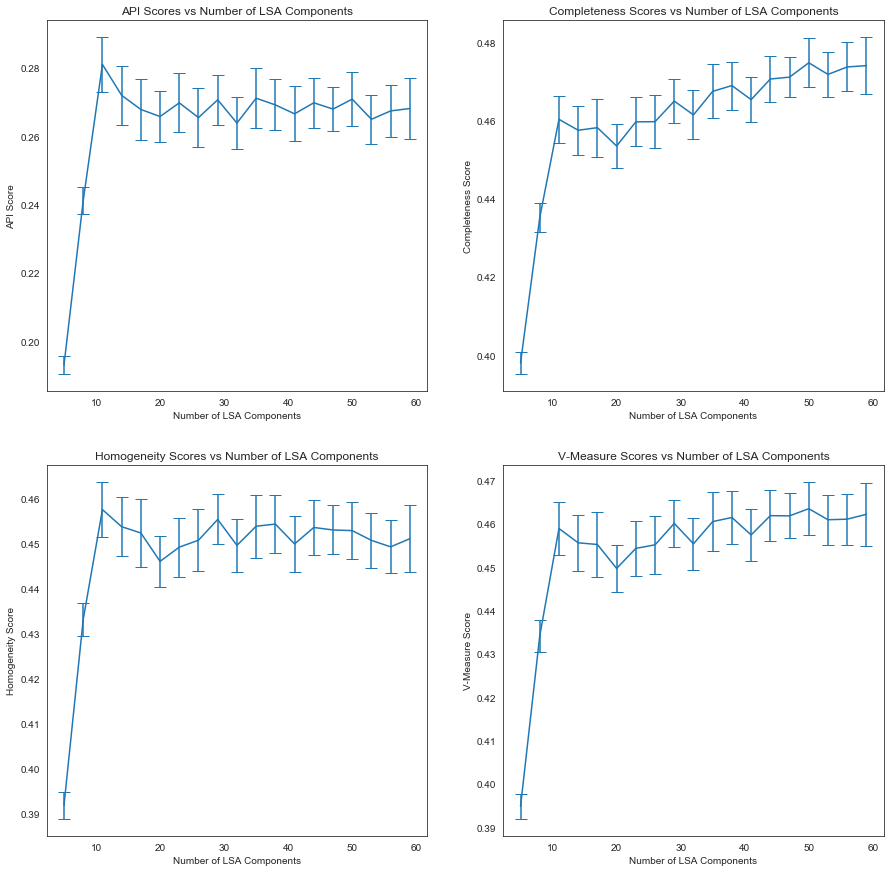

In [1057]:
X = scale(np.array(df_bow_500.drop(
    ['doc_', 'text_', 'president_'], 1).astype('float64')), axis = 1)
min_components = 5
max_components = 60
delta_components = 3
number_of_trials = 100
plotting_scores_vs_number_of_LSA_components(
    X, min_components, max_components, delta_components, number_of_trials)

After conducting 100 trials for each number of LSA Components we see that as long as we have roughly 12 components, our scores stay in the same range. I have run the code a few times with difference random_seeds, and each time we have different random peaks and valleys in the plots of these scores. Let's continue to use df_bow_500, scaling by sample, and using 20 LSA components as our best model. 

Now let's use a tf-idf document-term martix and see how it compares.

## tf-idf document-term matrix

In [795]:
# setting the parameters of our tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.6, # drop words that more than 60% of the presidents say
                             min_df=2, # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case 
                             use_idf=True,
                             # we definitely want to use inverse document frequencies 
                             # in our weighting
                             norm=u'l2', 
                             # we will normalize each row of our document term matrix 
                             # to have unit length. Thus, speeches that are longer 
                             # will not be farther from the origin than shorter speeches
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an extra 
                             # document existed that used every word once.  
                             # Prevents divide-by-zero errors
                            )

# fitting the vectorizer to distinguish between the 10 joined speeches for each president:
# we are choosing our features (terms) based on what would be best for determining 
# which president said that term. what would be "best" for making this determination 
# is given by our parameter choices of TfidfVectorizer.
vectorizer.fit(president_files_joined)

# with those features we then create the document-term matrix where each row is a single speech
X_tfidf = vectorizer.transform(np.array(df_train['text_']))


In [796]:
# creating a pandas data frame of our document term matrix
df_tfidf = pd.DataFrame(X_tfidf.toarray())
df_tfidf.columns = vectorizer.get_feature_names()
df_tfidf['president_'] = df_train['president_']
df_tfidf['text_'] = df_train['text_']
df_tfidf.head()

,00,002,003,006,01,010,029,038,04,041,...,youthful,yugoslavia,zealand,zealous,zealously,zero,zone,zones,president_,text_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,grant,To the House of Representatives: I have given ...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnson,Fellow-Citizens of the Senate and House of Rep...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,kennedy,"Vice President Johnson, Mr. Speaker, Mr. Chief..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,washington,Whereas it is the duty of all Nations to ackno...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,johnson,To the House of Representatives: I have consid...


### Using tf-idf 

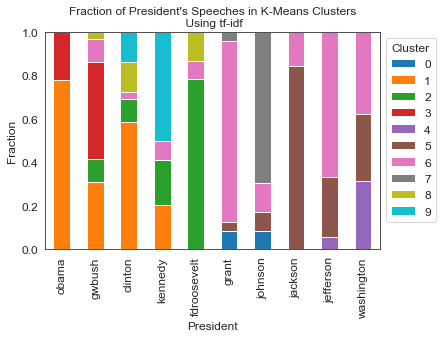

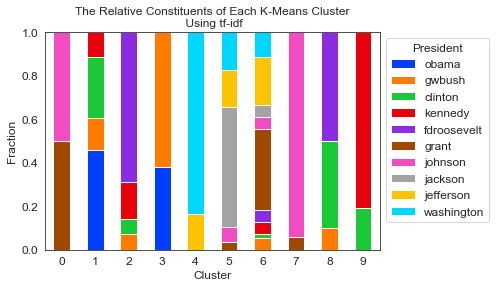

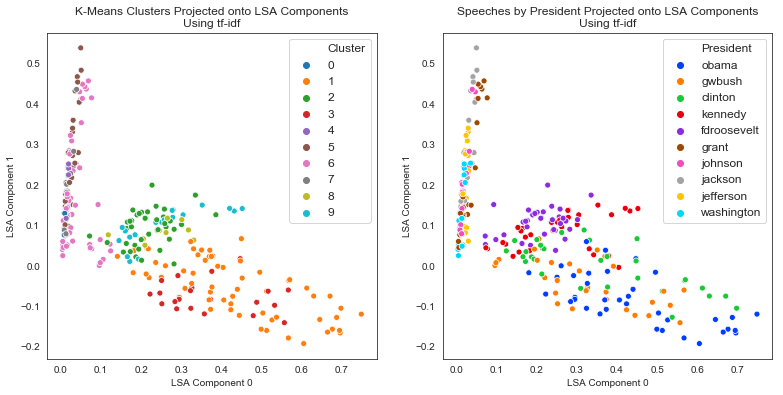

Using tf-idf
ARI score: 0.297 +/- 0.023
completeness score: 0.581 +/- 0.017
homogeneity score: 0.510 +/- 0.016
v-measure score: 0.543 +/- 0.015


In [1060]:
y_true = df_tfidf['president_']
n_clusters = 10
params = {}
description = 'tf-idf'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

We already have the best scores we have seen so far. Our ARI score is roughly 30%, and our v-measure score is 54%.

In our bar plot of the fraction of a presidents speeches in a given cluster, we see a nice flow of colors from the left most president, Obama, to the right most, Washington. This indicates that our clustering algorithm is clustering by president more effectivly than our previous algorithms. 

We also we two obvious clusters in our scatter plots. The five more recent presidents look to be in the lower loosely packed cluster, while the five less recent presidents are packed in that tight cluster that in the shape of a line. 

Let's see how well we can group the presidents speeches into two clusters.

### Using tf-idf matrix to cluster the presidents into two sets

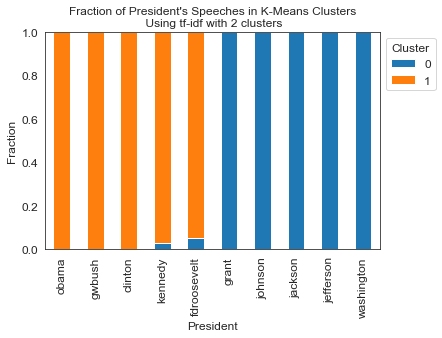

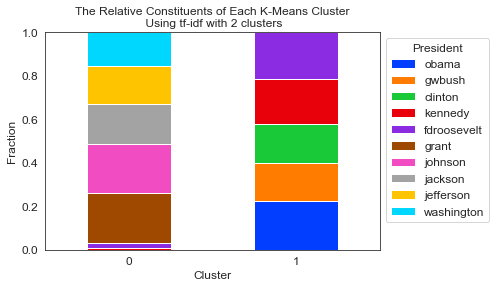

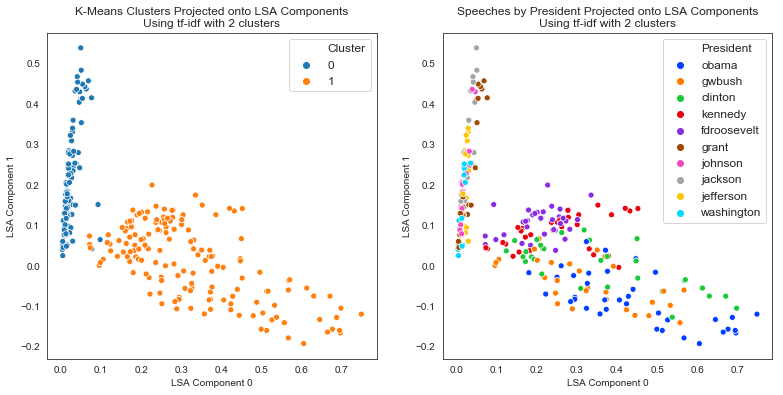

Using tf-idf with 2 clusters
ARI score: 0.180 +/- 0.002
completeness score: 0.927 +/- 0.014
homogeneity score: 0.274 +/- 0.004
v-measure score: 0.423 +/- 0.006


In [1061]:
y_true = df_tfidf['president_']
n_clusters = 2
params = {}
description = 'tf-idf with 2 clusters'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

Wow! That clusters the two sets of presidents almost perfectly. There is barely any speeches miscategorized, and the ones that are belong to presidents who are nearest in time to the other cluster. 

Let's try using LSA and see if we cant do a better job clusting by individual president with this tf-idf document-term matrix.

Note that there is not need to run trials with scaling since sklearn's tfidf vecotrizer has already scaled the data for us. 

### Using our tf-idf matrix and 5 LSA components

In [1066]:
lsa = TruncatedSVD(n_components=5, random_state=0)
X_tfidf_lsa = lsa.fit_transform(X_tfidf)
y_true = df_tfidf['president_']
n_clusters = 10
params = {}
description = 'tf-idf and LSA-5'
k_means_scores(X_tfidf_lsa, y_true, n_clusters, params, description)

Using tf-idf and LSA-5
ARI score: 0.231 +/- 0.007
completeness score: 0.505 +/- 0.014
homogeneity score: 0.475 +/- 0.010
v-measure score: 0.490 +/- 0.011


Using 5 LSA Components with our tf-idf document-term matrix did not work as well as not using LSA. Let's see a plot of scores versus number of LSA components.

### Plotting scores versus number of LSA components for our tf-idf matrix

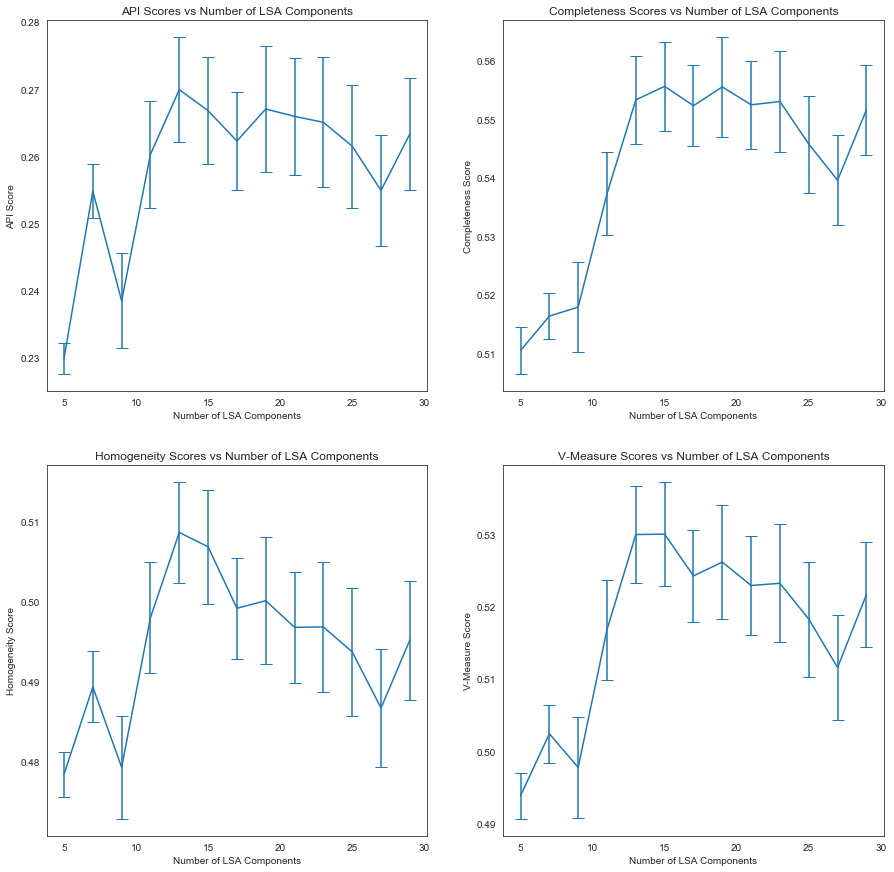

In [1070]:
X = X_tfidf
min_components = 5
max_components = 30
delta_components = 2
number_of_trials = 100
plotting_scores_vs_number_of_LSA_components(
    X, min_components, max_components, delta_components, number_of_trials)

None of these ARI scores are comparable to the ARI score of our tfidf matrix with no LSA. Maybe we just need more components of LSA to reach that ARI score. Let's run make these plots once more but with more LSA components. 

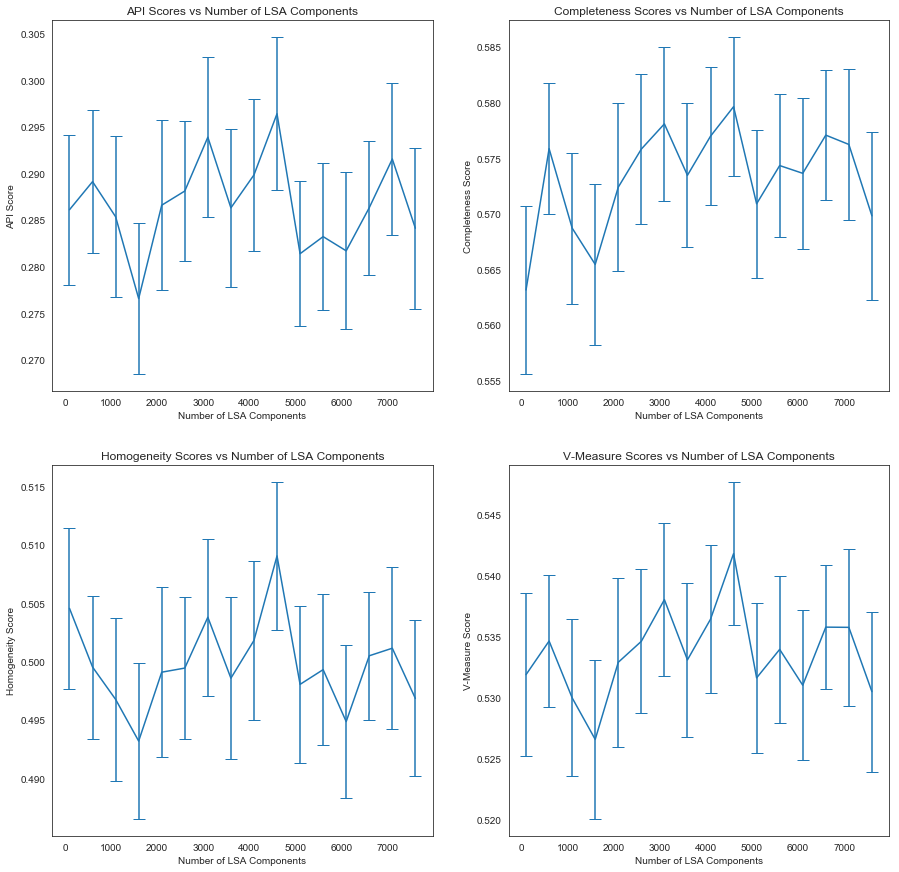

In [1072]:
X = X_tfidf
min_components = 100
max_components = 8000
delta_components = 500
number_of_trials = 100
plotting_scores_vs_number_of_LSA_components(X, min_components, max_components, delta_components, number_of_trials)

We still don't see an mean ARI score of 0.30. While a few of these peaks to have errorbars that reach past an ARI score of 0.30, none of them how a score that is significantly higher than 0.30. It seems using the sparce orignial matrix yields the best result for clustering by president. Let's try changing the parameters of our tf-idf vectorizer.

### Iterating through different max_df and min_df parameters for our tf-idf document-term matrix

What do these parameters mean? If a term is said by more than df_max (an integer) presidents we will not include that term in our tf-idf matrix. If a term is said by less than df_min (an integer) presidents we will not include that term in our tf-idf matrix. 

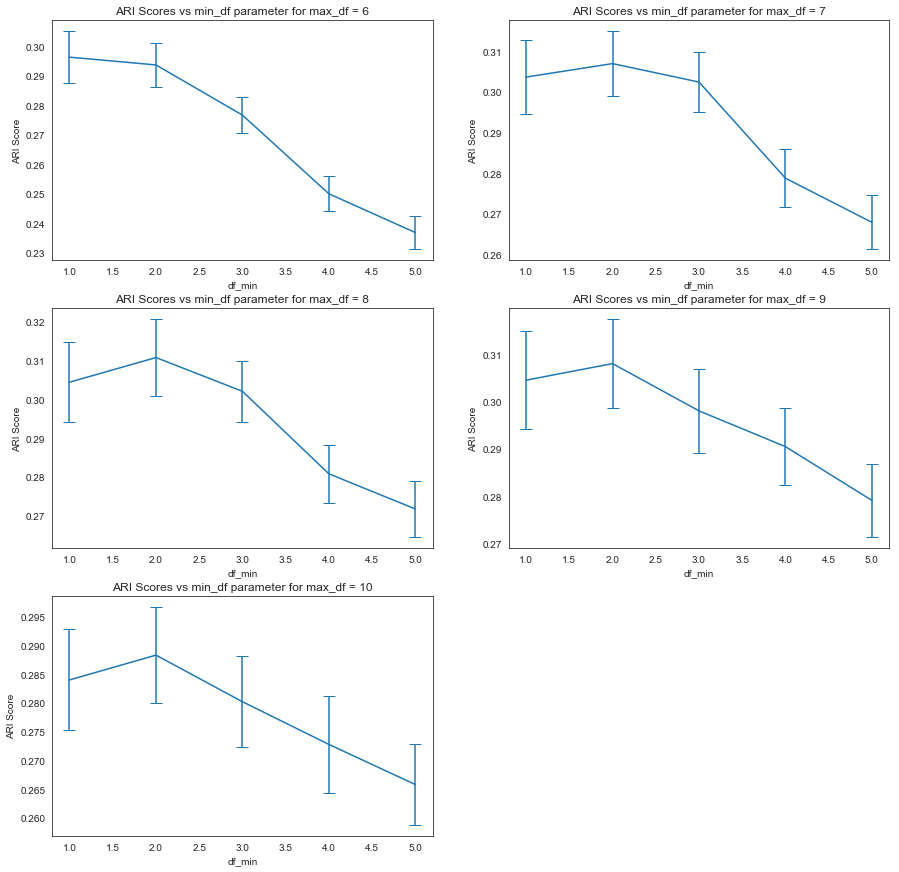

In [1090]:
# parameter values we will explore
max_dfs = [6,7,8,9,10]
min_dfs = [1,2,3,4,5]

# We will calculate run 100 trails for every combination of df_min and df_max
# and calculate the ARI score for each trial.
number_of_trials = 100

# Initializing our figure.
plt.figure(figsize=(15,15))
for max_df in max_dfs:
    
    # initializing lists to store ARI scores statistics for one df_max value
    # each element is a value for a specific df_min value.
    mean_ari_scores = []
    sigma2_ari_scores = []
    for min_df in min_dfs:
        # initializing lists to store ARI scores
        ari_scores = []
                # setting the parameters of our tf-idf vectorizer
        vectorizer = TfidfVectorizer(max_df=max_df, 
                                     # drop words that more than 70% of the presidents say
                             min_df=min_df, 
                                     # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, 
                                     # convert everything to lower case 
                             use_idf=True,
                                     # we definitely want to use inverse document 
                                     # frequencies in our weighting
                             norm='l2', 
                                     # we will normalize each row of our document 
                                     # term matrix to have unit length.    
                                     # Thus, speeches that are longer will not 
                                     # be farther from the origin than shorter speeches
                             smooth_idf=True 
                                     # Adds 1 to all document frequencies, 
                                     # as if an extra document existed that used every word once.  
                                     # Prevents divide-by-zero errors
                            )

        # fitting the vectorizer to distinguish between the 10 joined speeches for each president:
        # we are choosing our features (terms) based on what would be best for determining 
        # which president said that term.
        # what would be "best" for making this determination is given by our parameter 
        # choices of TfidfVectorizer.
        vectorizer.fit(president_files_joined)

        # with those features we then create the document-term matrix where 
        # each row is a single speech
        X_tfidf = vectorizer.transform(np.array(df_train['text_']))

        # our true labels for the clustering
        y_true = df_tfidf['president_']
        
        # we are attemping to cluster each president individually, thus we want 10 clusters 
        n_clusters = 10
        
        # Looping through k-means ten times and recording statistics.
        for trial in range(number_of_trials):

            # we will use scikit-learns MiniBatchKMeans function
            minibatchkmeans = MiniBatchKMeans(
                **params, n_clusters=n_clusters, random_state=trial)

            # fitting k-means and predicting on our data
            y_pred = minibatchkmeans.fit_predict(X_tfidf)

            # Calculating an ARI score for a trial
            ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))

        # adding the mean score of ARI scores (for a specific combination of df_min and df_max)
        # to the list of mean scores for a given df_max. 
        mean_ari_scores.append(np.mean(ari_scores))
        sigma2_ari_scores.append(2*np.std(ari_scores)/np.sqrt(number_of_trials))

    # Plotting the 5 figures.    
    plt.subplot(3,2,max_df-5)
    plt.errorbar(min_dfs, mean_ari_scores, yerr = sigma2_ari_scores, capsize=6)
    plt.title('ARI Scores vs df_min parameter for df_max = {}'.format(max_df))
    plt.xlabel('df_min')
    plt.ylabel('ARI Score')


Alright, after 100 trials for each combination of df_min and df_max, df_max = 8 and df_min = 2 is our winning combination. While the errorbars of these plots leave us a bit uncertain of which combination for df_min and df_max is truly best, let's use df_max = 8 and df_min = 2 since this is the combination with the highest mean ARI value we found. 

### Analyzing our winning document-term matrix

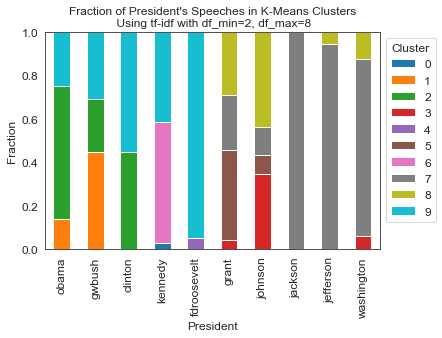

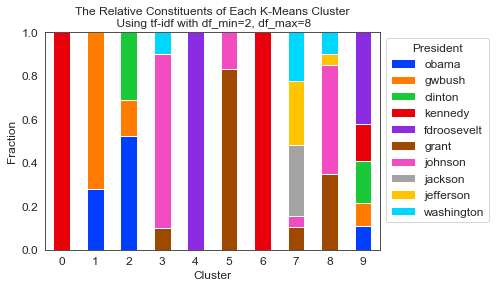

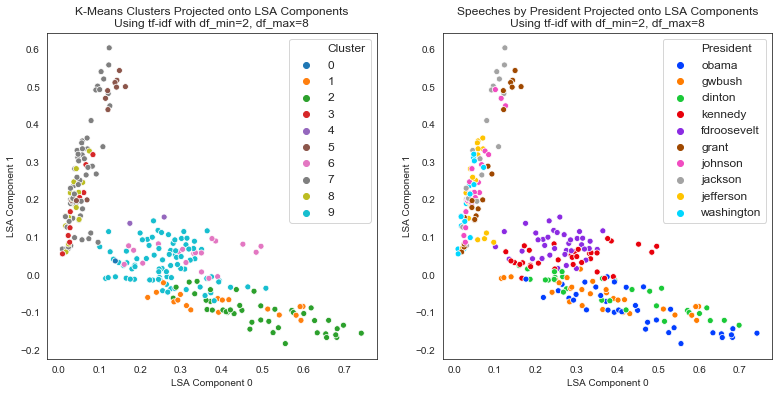

Using tf-idf with df_min=2, df_max=8
ARI score: 0.314 +/- 0.028
completeness score: 0.599 +/- 0.025
homogeneity score: 0.523 +/- 0.020
v-measure score: 0.558 +/- 0.018


In [1096]:
# setting the parameters of our tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=8, 
                             # drop words that more than 8 of the presidents say
                             min_df=2, 
                             # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, 
                             # convert everything to lower case 
                             use_idf=True,
                             # we definitely want to use inverse document 
                             # frequencies in our weighting
                             norm='l2', 
                             # we will normalize each row of our document-term 
                             # matrix to have unit length.
                             # Thus, speeches that are longer will not be farther 
                             # from the origin than shorter speeches
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an 
                             #extra document existed that used every word once.  
                             #Prevents divide-by-zero errors
                            )

# fitting the vectorizer to distinguish between the 10 joined speeches for each president:
# we are choosing our features (terms) based on what would be best for determining 
# which president said that term.
# what would be "best" for making this determination is given by our parameter 
# choices of TfidfVectorizer.
vectorizer.fit(president_files_joined)

# with those features we then create the document-term matrix where each row is a single speech
X_tfidf = vectorizer.transform(np.array(df_train['text_']))

# creating the pandas dataframe of this document-term matrix
df_tfidf = pd.DataFrame(X_tfidf.toarray())
df_tfidf.columns = vectorizer.get_feature_names()
df_tfidf['president_'] = df_train['president_']
df_tfidf['text_'] = df_train['text_']

# applying our k_means_analysis function to this document-term matrix
y_true = df_tfidf['president_']
n_clusters = 10
params = {}
description = 'tf-idf with df_min=2, df_max=8'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)


Out of all the document-term matrices we have created, this is our winning matrix for using k-means clustering to cluster speeches by president. We have an mean ARI score of 0.31. Our mean completeness score is 0.60 and our mean homogeneity score is 0.52. We can infer our completeness score from the first bar plot. We see that F. D. Roosevelt speeches, Andrew Jackson speeches and Thomas Jefferson speeches are each clustered into predominatly one cluster. This leads to our high completeness score. We can infer our homogeneity score from our second bar plot. Cluster '0', Cluster '4', and Cluster '6' are entirely comprised of one presidents speeches, raising our homogeneity score. However, Cluster '9' is comprised be five different presidents speeches, which lowers this score. We are left with an average homogeneity score of 0.52. Again, we are only plotting the last of the ten trials of clustering that are used to calculate to the mean scores we see. 

Perhaps this document-term matrix will yeild strong clustering when grouping the presidents into our two groups (the five more and less recent presidents). Let's see.

### Creating two clusters with our winning matrix 

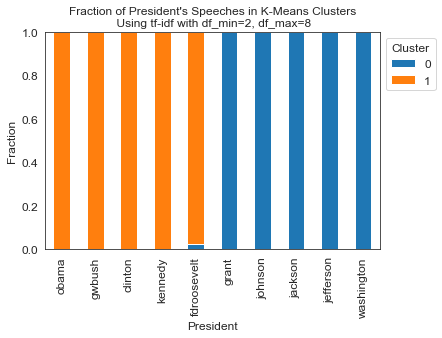

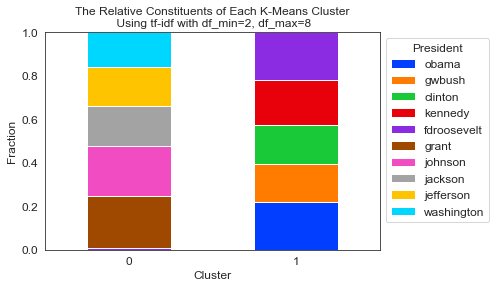

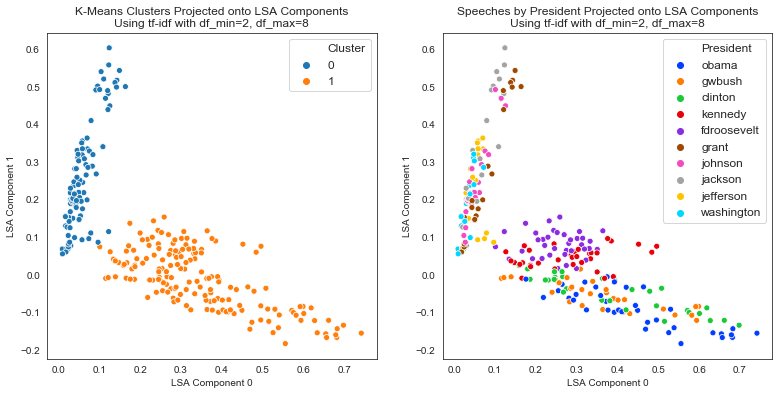

Using tf-idf with df_min=2, df_max=8
ARI score: 0.186 +/- 0.001
completeness score: 0.977 +/- 0.005
homogeneity score: 0.287 +/- 0.001
v-measure score: 0.443 +/- 0.002


In [1100]:
n_clusters = 2
params = {}
description = 'tf-idf with df_min=2, df_max=8'
k_means_analysis(X_tfidf, y_true, n_clusters, params, description)

That is an extremely high completeness score - it's mean is roughly 0.98. We see this from the first bar plot. Almost every speech by each president is clustered into one of the two clusters. Just a few of F. D. Roosevelt's speeches are clustered into the less recent president cluster. One misclassified speech can be spotted from the scatter plots. In the scatter plot on the right, the purple (F.D.Roosevelt) datapoint at roughly (0.12, 0.12) is colored blue in the scatter plot on the left. The blue cluster in the left scatter plot is the less recent president cluster. That is the only point that looks to be misclassified. 

Let's not forget, these plots are plots of the last of the ten trials that gave us our scoring statistics. It seems a bit silly to investigate that 10th trial in such a greater depth than the other nine. The important take away is that this document-term matrix with k-means clustering is excellent at clustering president by time period. Still, let's see if that is the only misclassified point. We can't not know!

Let's calculate the scores as if we were trying to cluster speeches by these two eras. 

The Contingency Table:
president_era_  less_recent  more_recent
row_0                                   
0                       100            1
1                         0          164


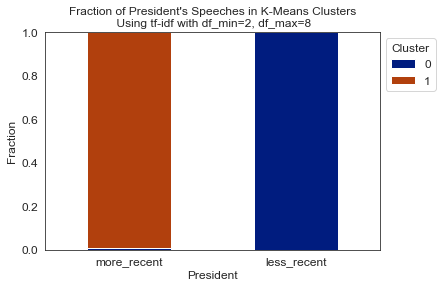

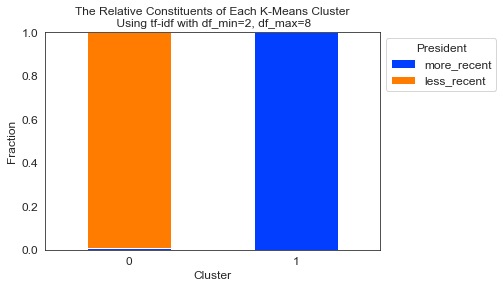

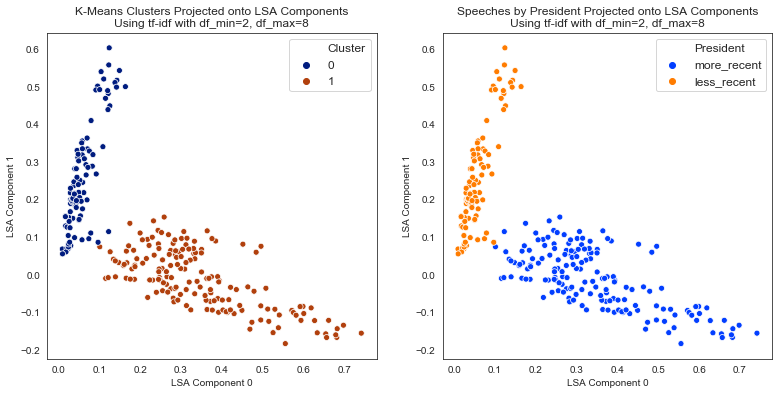

Using tf-idf with df_min=2, df_max=8
ARI score: 0.986 +/- 0.003
completeness score: 0.969 +/- 0.007
homogeneity score: 0.971 +/- 0.006
v-measure score: 0.970 +/- 0.006


In [1172]:
df_tfidf['president_era_'] = np.where(
    np.isin(df_tfidf['president_'], 
            ['obama','gwbush','clinton','kennedy','fdroosevelt']),
    'more_recent', 'less_recent')
y_true = df_tfidf['president_era_']

n_clusters = 2
params = {}
description = 'tf-idf with df_min=2, df_max=8'

X = X_tfidf.toarray()

# we will cluster our data ten times and calculate statistics of 
# our metrics for cluster evaluation.
number_of_trials = 10

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # we will use scikit-learns MiniBatchKMeans function
    minibatchkmeans = MiniBatchKMeans(
        **params, n_clusters=n_clusters, random_state=trial)
        # this uses the same 10 different random_states each time the code is run)

    # fitting k-means and predicting on our data
    y_pred = minibatchkmeans.fit_predict(X)
    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[['more_recent', 'less_recent']]
print("The Contingency Table:")
print(pd.crosstab(y_pred, y_true))

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(
    normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = ['more_recent', 'less_recent']


# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's 
# presidental constituents
crosstab_normalized_T = pd.DataFrame(normalize(
    np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('dark')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = ['more_recent', 'less_recent'])
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in K-Means Clusters\n Using '
          + str(description), fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(2))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(['more_recent','less_recent'], title = 'President',
           title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each K-Means Cluster\n Using '
          + str(description), fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('dark')    
plt.subplot(1, 2, 1)
plt.title('K-Means Clusters Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4',
                               'C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true',
                      hue_order = ['more_recent', 'less_recent'],
                      palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()

print('Using {}'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(ari_scores), 3), 
    round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(completeness_scores), 3), 
    round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(homogeneity_scores), 3), 
    round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(v_measure_scores), 3), 
    round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

That was the only misclassified point! We can see that from the contingency table. Our scores are all extremely high. Our ARI score is roughly 0.986. Almost all the pairs of points are of the same kind (both point are in the same cluster or each point is in a different cluster) when clustering by our model or when clustering by true labels. We can see from our two bar plots that we have very high completeness and homogeneity - all four bars are practically one solid color. 

While clustering by era is not the goal of our clustering algorithm. We certainly have done a good job of it.

## Using the Mean-Shift Algorithm on Our Winning tf-idf Matrix

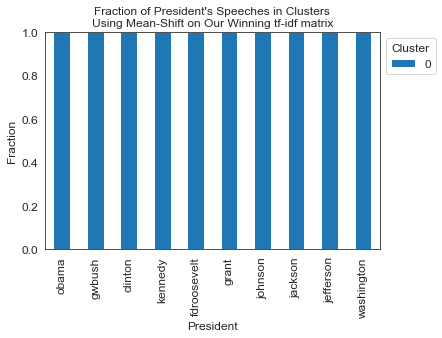

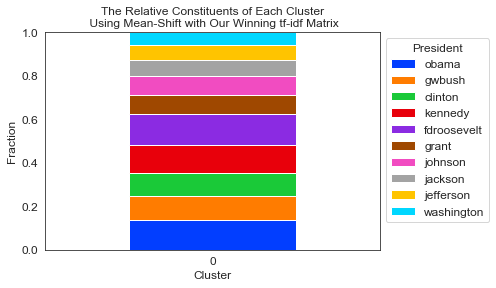

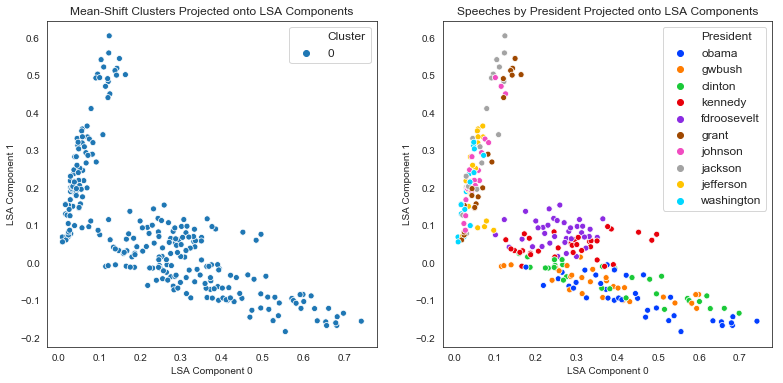

Number of estimated clusters: 1
Using Mean-Shift with Our Winning tf-idf Matrix
ARI score: 0.000 +/- 0.000
completeness score: 1.000 +/- 0.000
homogeneity score: -0.000 +/- 0.000
v-measure score: -0.000 +/- 0.000


In [1173]:
X = X_tfidf.toarray()
# we will cluster our data ten times and calculate statistics of our metrics for cluster evaluation.
number_of_trials = 10


y_true = df_tfidf['president_']

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # Here we set the bandwidth. This function automatically derives a bandwidth
    # number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(X, quantile = .3)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    y_pred = ms.fit_predict(X)

    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[presidents]

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = [presidents]

# Count our clusters.
n_clusters = len(ms.cluster_centers_)

# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's presidental constituents
crosstab_normalized_T = pd.DataFrame(normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('tab10')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = presidents)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in Clusters\n' +
          'Using Mean-Shift on Our Winning tf-idf matrix', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(presidents, title = 'President', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each Cluster\n Using Mean-Shift with Our Winning tf-idf Matrix', fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('tab10')    
plt.subplot(1, 2, 1)
plt.title('Mean-Shift Clusters Projected onto LSA Components', fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components', fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents, palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()


print("Number of estimated clusters: {}".format(n_clusters))

print('Using Mean-Shift with Our Winning tf-idf Matrix'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(round(np.mean(ari_scores), 3),
                                   round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(round(np.mean(completeness_scores), 3),
                                   round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(round(np.mean(homogeneity_scores), 3),
                                   round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(round(np.mean(v_measure_scores), 3),
                                   round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

After trying many values for the quantile parameter of the sklearn's estimate_bandwidth function, which estimates the bandwidth that will be used in the mean-shift algorithm, I have not found any value that results in more than 1 cluster. It seems mean-shift is not a good algorithm for clustering this document-term matrix. 

## Using the Spectral Clustering Algorithm on Our Winning tf-idf Matrix

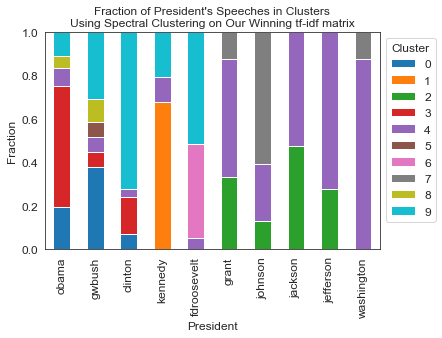

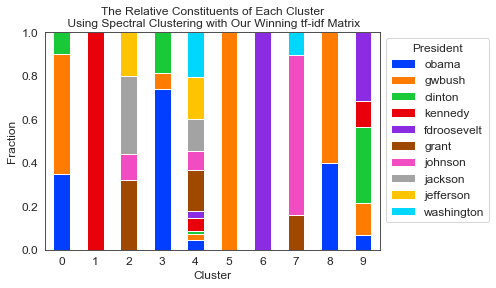

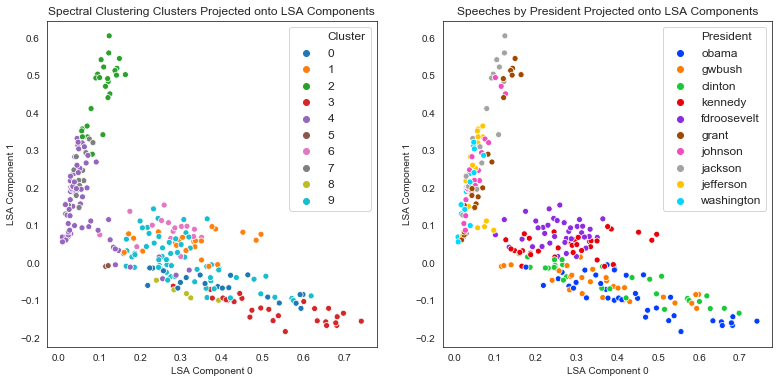

Using Spectral Clustering with Our Winning tf-idf Matrix
ARI score: 0.196 +/- 0.023
completeness score: 0.487 +/- 0.020
homogeneity score: 0.425 +/- 0.021
v-measure score: 0.454 +/- 0.020


In [1176]:
X = X_tfidf.toarray()
# we will cluster our data ten times and calculate statistics of our metrics for cluster evaluation.
number_of_trials = 10

# We know we're looking for three clusters.
n_clusters=10

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters, random_state=trial)
    
    #Predicted clusters.
    y_pred = sc.fit_predict(X)

    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[presidents]

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = [presidents]


# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's presidental constituents
crosstab_normalized_T = pd.DataFrame(normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('tab10')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = presidents)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in Clusters\n' +
          'Using Spectral Clustering on Our Winning tf-idf matrix', fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(len(presidents)))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(presidents, title = 'President', title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each Cluster\n Using Spectral Clustering with Our Winning tf-idf Matrix', fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('tab10')    
plt.subplot(1, 2, 1)
plt.title('Spectral Clustering Clusters Projected onto LSA Components', fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President Projected onto LSA Components', fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true', hue_order = presidents, palette = 'bright', data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()


print('Using Spectral Clustering with Our Winning tf-idf Matrix'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(round(np.mean(ari_scores), 3),
                                   round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(round(np.mean(completeness_scores), 3),
                                   round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(round(np.mean(homogeneity_scores), 3),
                                   round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(round(np.mean(v_measure_scores), 3),
                                   round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

Relative to the other algorithms we have seen, Specral Clustering does an alright job of clustering the by president. A mean ARI score of roughly 0.20 is not that poor compared to some of the clusterings we have seen. It's v-measure score is not relatively terrible either. Let's try Affinity Propagation. 

## Using the Affinity Propagation Algorithm on Our Winning tf-idf Matrix

In [1147]:

X = X_tfidf.toarray()
# we will cluster our data ten times and calculate statistics of our metrics for cluster evaluation.
number_of_trials = 10

# the Affinity Propogation Algorithm will produce the same output each time it is run.
# Thus, there is no need from trials.
# We will use the previous code for convinience, but not there is only one score we are taking the mean of.
ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

    
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation()

y_pred = af.fit_predict(X)

ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
completeness_scores.append(metrics.completeness_score(y_true, y_pred))
homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

print('Affinity Propagation\'s estimated number of clusters: {}'.format(n_clusters))

print('Using Affinity Propagation with Our Winning tf-idf Matrix'.format(description))    
print('ARI score: {:.3f}'.format(round(np.mean(ari_scores), 3)))
print('completeness score: {:.3f}'.format(round(np.mean(completeness_scores), 3)))
print('homogeneity score: {:.3f}'.format(round(np.mean(homogeneity_scores), 3)))
print('v-measure score: {:.3f}'.format(round(np.mean(v_measure_scores), 3)))

Affinity Propagation's estimated number of clusters: 33
Using Affinity Propagation with Our Winning tf-idf Matrix
ARI score: 0.233
completeness score: 0.489
homogeneity score: 0.702
v-measure score: 0.577


There is only one unique output of Affinity Propogation for a given input matrix. Thus, we cannot run many trials. We simply have one of each score for this algorithm. Also, we have chosen to not show the plots. With our Affinity Propogation algorithm chosing 33 clusters, the plots are too overwelming and cluttered.

From the scores, we see that Affinity Propagation does a relatively fair job at clustering the data by president. We achieve an ARI score of 0.23, which is an okay score compared to what we have seen. This homogeneity score is the highest we have seen, but that is because we have 33 clusters. The more clusters we have, the more homogeneous our clusters will be. If we had one cluster for every speech, then we would have a perfect homogeneity score, but this would be really unhelpful clustering.

# Optimal Clustering Conclusion

Thus k-means remains the best clustering for our winning document-term matrix. Of course, we used k-means as our algorithm to determine the winning document-term matrix. We could have tailored our winning document-term matrix to a different clustering algorithm. For instance, a certain scaling of df_bow_500 might be the winning matrix for affinity propagation. Perhaps, its ARI score would be the highest we have seen. We have not covered all the possibilities. One can search ad nauseum for the optimal combonation of features and clustering algorithms. The possibilities are endless. We had chose our plan for determining features and clustering algorithms and adhered to the plan. 

It is unfortunate that we were unable to find a model with higher scores. Grouping the speeches by president does not seem to be that difficult of a task. The names and dates within each speech should give a really strong indication of who gave the speech. George Washington, who served as president in the 1700's, will likely never mention any date in the 1800's, 1900's, or 2000's. He will also never say the name 'Obama' or 'Lincoln.' Also the current affairs during each presidency should all but give away the president speaking. President's will mention past current affairs some. But the frequency of the words concerning those affairs during the time of their speech should be high. Perhaps, some more unique features would be best. We have only used the standard Bag of Words and tf-idf features in this treatment. 

We did succeed in clustering the speeches into two clusters - one contain speeches given by the five more recent presidents and another with speeches from the five less recent. We did that to a very high accuracy. We achieved an ARI score of 0.98. While this kind of clustering was not our goal, we did succeed in this at least. 


### Our winning combination of features and clustering algorithm when clustering by president:

Using df_tfidf with df_min=2 and df_max=8

ARI score: 0.314 +/- 0.028

completeness score: 0.599 +/- 0.025

homogeneity score: 0.523 +/- 0.020

v-measure score: 0.558 +/- 0.018


### Our winning combination of features and clustering algorithm when clustering by president's era:

Using df_tfidf with df_min=2 and df_max=8

ARI score: 0.986 +/- 0.003

completeness score: 0.969 +/- 0.007

homogeneity score: 0.971 +/- 0.006

v-measure score: 0.970 +/- 0.006





# Evaluating our winning clustering algorithm on our testing data

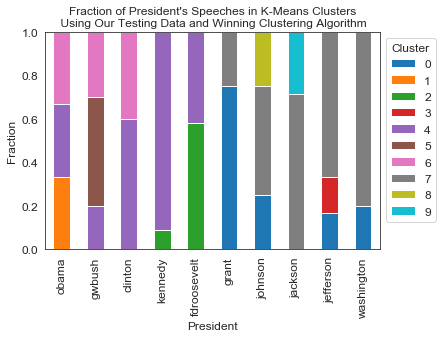

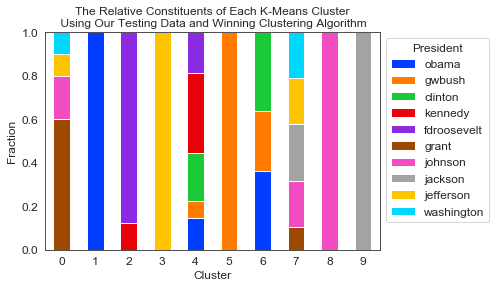

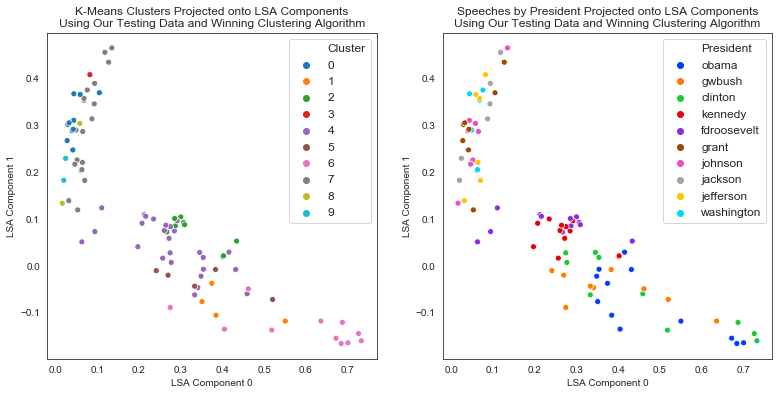

Using Our Testing Data and Winning Clustering Algorithm
ARI score: 0.246 +/- 0.013
completeness score: 0.613 +/- 0.018
homogeneity score: 0.518 +/- 0.012
v-measure score: 0.561 +/- 0.012


In [1333]:
# fitting the vectorizer to the training data just as we did before.
# This code is copied.
# setting the parameters of our tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=8, 
                             # drop words that more than 8 of the presidents say
                             min_df=2, 
                             # only use words that at least two presidents said
                             stop_words='english', 
                             lowercase=True, 
                             # convert everything to lower case 
                             use_idf=True,
                             # we definitely want to use inverse document 
                             # frequencies in our weighting
                             norm='l2', 
                             # we will normalize each row of our document-term 
                             # matrix to have unit length.
                             # Thus, speeches that are longer will not be farther 
                             # from the origin than shorter speeches
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an 
                             #extra document existed that used every word once.  
                             #Prevents divide-by-zero errors
                            )


# fitting the vectorizer to distinguish between the 10 joined speeches 
# for each president:
# we fit the vecorizer on the training data
vectorizer.fit(president_files_joined)

# Now we involve the testing data.
# We use the features the vectorizer chose when 
# fitting to the training data, and transform the testing data.
X_tfidf_test = vectorizer.transform(np.array(df_test['text_']))

# creating the pandas dataframe of this document-term matrix
df_tfidf_test = pd.DataFrame(X_tfidf_test.toarray())
df_tfidf_test.columns = vectorizer.get_feature_names()
df_tfidf_test['president_'] = df_test['president_']
df_tfidf_test['text_'] = df_test['text_']

# applying our k_means_analysis function to this document-term matrix
y_true_test = df_tfidf_test['president_']
n_clusters = 10
params = {}
description = 'Our Testing Data and Winning Clustering Algorithm'
k_means_analysis(X_tfidf_test, y_true_test, n_clusters, params, description)

Our winning clustering algorithm's performance on our testing data is not quite as strong as it's performance on the training data it was tailored to, but it is somewhat similar. Here, we have an ARI score of roughly 0.25, which is lower than our training data's ARI score of 0.31. It is approximately 20% lower. Our testing data's completeness score is very similar to the training data's. They are both roughly 60%. Our testing data's homogeneity score is also very similar to the training data's. It follows that we have similar v-measure scores.

While the ARI score is lower, the other scores remain the same. Is our clustering stable? It could be more stable - we could have more similar ARI scores. Still, I feel our clustering is not wildly unstable. If we had more data points to test on and train with, we could have more confidence about the stability of our clustering. With the data we have, it is reasonable to state that our clustering is adequately stable. 

By looking at the first bar plot (which again is a visualization of the last of the ten trials that gave us our score statistics), we notice that most presidents are predominantly clustered into one cluster. Kennedy, Grand, Jackson Jefferson, and Washington are all clustered well in this way. This gives rise to our higher completeness score. Our second barplot informs us that clusters '0', '1', '2', '3', '5', '8', and '9' all have a president they primarily represent. It is reasuring to know that these clusters are representative of a given president. 

We also see a strong similarity to the training data in the scatterplots. We again have two visible clusters. The tall skinny cluster in the top left once again contains the less recent presidents and the wider cluster in the bottom right contains the more recent ones. The first barplot and first scatter plot suggest that our algorithm should be proficient at clustering by presidental era. We see this via the colors. Five of the ten describe one of the two time periods. 

Let's see how our model performs when clustering the testing data by presidential era. 

## Evaluation our winning model when clustering our testing data by presidential era

The Contingency Table:
president_era_  less_recent  more_recent
row_0                                   
0                        34            0
1                         0           55


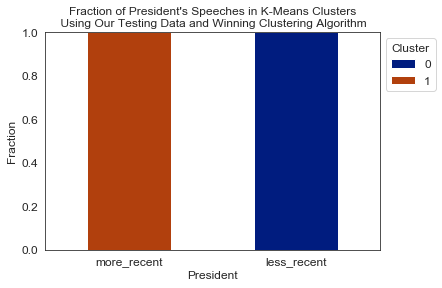

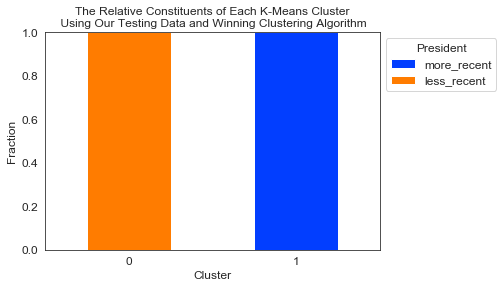

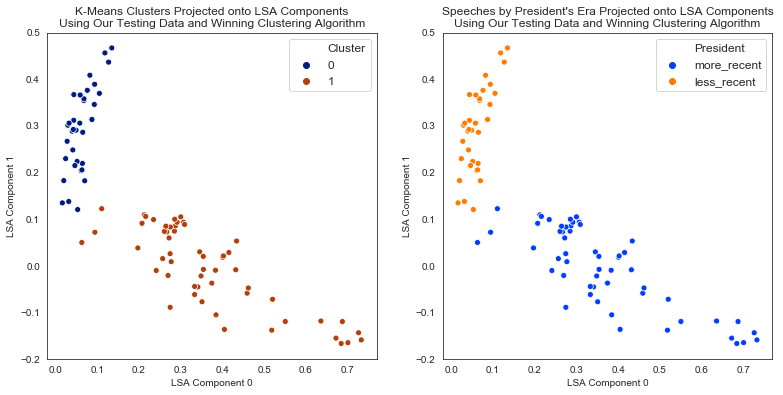

Using Our Testing Data and Winning Clustering Algorithm
ARI score: 0.900 +/- 0.040
completeness score: 0.887 +/- 0.035
homogeneity score: 0.892 +/- 0.035
v-measure score: 0.889 +/- 0.035


In [1271]:
df_tfidf_test['president_era_'] = np.where(
    np.isin(df_tfidf_test['president_'], 
            ['obama','gwbush','clinton','kennedy','fdroosevelt']),
    'more_recent', 'less_recent')
y_true = df_tfidf_test['president_era_']

n_clusters = 2
params = {}
description = 'Our Testing Data and Winning Clustering Algorithm'

X = X_tfidf_test.toarray()

# we will cluster our data ten times and calculate statistics 
# of our metrics for cluster evaluation.
number_of_trials = 100

ari_scores = []
completeness_scores = []
homogeneity_scores = []
v_measure_scores = []

for trial in range(number_of_trials):

    # we will use scikit-learns MiniBatchKMeans function
    minibatchkmeans = MiniBatchKMeans(
        **params, n_clusters=n_clusters, random_state=trial)
        # this uses the same 10 different random_states each time the code is run)

    # fitting k-means and predicting on our data
    y_pred = minibatchkmeans.fit_predict(X)
    ari_scores.append(metrics.adjusted_rand_score(y_true, y_pred))
    completeness_scores.append(metrics.completeness_score(y_true, y_pred))
    homogeneity_scores.append(metrics.homogeneity_score(y_true, y_pred))
    v_measure_scores.append(metrics.v_measure_score(y_true, y_pred))

# we will print our the score after our plots

# calculating the contigency table for our clustering
# this will be clustering of the last of the trials.
# we have to choose one of the ten clusterings to evaluate.

contigency_table = pd.crosstab(y_pred, y_true)[['more_recent', 'less_recent']]
print("The Contingency Table:")
print(pd.crosstab(y_pred, y_true))

# Normalizing the contigency table. 
# We seek to know the percentage of each presidents speeches in a given cluster.
contigency_table_normalized = pd.DataFrame(
    normalize(np.array(contigency_table),  axis = 0, norm = 'l1'))
contigency_table_normalized.columns = ['more_recent', 'less_recent']


# plotting a very similar graph from the transpose of the contingency matrix
# normalizing the crosstab scores so that we can see a given cluster's 
# presidental constituents
crosstab_normalized_T = pd.DataFrame(
    normalize(np.array(contigency_table).T,  axis = 0, norm = 'l1'))
crosstab_normalized_T.columns = range(n_clusters)




# ploting this contigency table as a staked bar plot
sns.set_palette('dark')
ax3 = contigency_table_normalized.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax3.set(xticklabels = ['more_recent', 'less_recent'])
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.title('Fraction of President\'s Speeches in K-Means Clusters\n Using '
          + str(description), fontsize = 12)
plt.xlabel('President', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(title = 'Cluster', title_fontsize = 12, bbox_to_anchor=(1, 1),
           prop={'size': 12})
plt.ylim(0,1)
plt.show()

# plotting a presidents cluster breakdown
sns.set_palette('bright')
ax4 = crosstab_normalized_T.T.plot(kind='bar', stacked=True, figsize = (6,4))
ax4.set(ylabel='Fraction', xlabel='Cluster', xticklabels = range(2))
plt.xticks(fontsize = 12, rotation='horizontal')
plt.yticks(fontsize = 12)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Fraction', fontsize = 12) 
plt.legend(['more_recent','less_recent'], title = 'President',
           title_fontsize = 12, bbox_to_anchor=(1, 1), prop={'size': 12})
plt.ylim(0,1)
plt.title('The Relative Constituents of Each K-Means Cluster\n Using '
          + str(description), fontsize = 12)
plt.show()


# making a two scatter plots of the clusters labeled by predicted cluster and true class. 
# We will plot their projection onto the two primary LSA components.

# creating a data frame with the two LSA components
lsa2 = TruncatedSVD(n_components=2)
X_lsa2 = lsa2.fit_transform(X)
df_lsa2 = pd.DataFrame(X_lsa2)
df_lsa2['y_true'] = y_true
df_lsa2['y_pred'] = y_pred
df_lsa2['y_pred'] = df_lsa2['y_pred'].astype(str)

# plotting the speech along the 2 principal compontents of LSA (Latent Semantic Analysis) 
plt.figure(figsize=(13,6))
sns.set_palette('dark')    
plt.subplot(1, 2, 1)
plt.title('K-Means Clusters Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax1 = sns.scatterplot(x = 0, y = 1, hue = 'y_pred', 
                      palette=['C0', 'C1', 'C2','C3','C4',
                               'C5','C6','C7','C8','C9'][:n_clusters], data = df_lsa2)
legend = ax1.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("Cluster")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')

plt.subplot(1, 2, 2)
plt.title('Speeches by President\'s Era Projected onto LSA Components\nUsing '
          + str(description), fontsize = 12)
ax2 = sns.scatterplot(x = 0, y = 1, hue = 'y_true',
                      hue_order = ['more_recent', 'less_recent'], palette = 'bright',
                      data = df_lsa2)
legend = ax2.legend(fontsize = 10, title_fontsize = 12, prop={'size': 12})
legend.texts[0].set_text("President")
plt.xlabel('LSA Component 0')
plt.ylabel('LSA Component 1')
plt.show()

print('Using {}'.format(description))    
print('ARI score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(ari_scores), 3),
    round(2*np.std(ari_scores)/np.sqrt(number_of_trials), 3)))
print('completeness score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(completeness_scores), 3),
    round(2*np.std(completeness_scores)/np.sqrt(number_of_trials), 3)))
print('homogeneity score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(homogeneity_scores), 3),
    round(2*np.std(homogeneity_scores)/np.sqrt(number_of_trials), 3)))
print('v-measure score: {:.3f} +/- {:.3f}'.format(
    round(np.mean(v_measure_scores), 3),
    round(2*np.std(v_measure_scores)/np.sqrt(number_of_trials), 3)))

We see that our model performs very well when clustering the speeches into the two eras. We ran the model 100 times on the testing data to achieve these scores with a low uncertainty. With less data to cluster, we have more variance in our models performance (thus the greater number of trials). We plotted the hundredth trial, and we see that all the points are clustered perfectly! Our ARI score is very high 0.90 with a roughly 0.04 uncertainty.

## Conclusion regarding Clustering on the Testing Data

Our clustering algorithm does not perform quite as well on the testing data as it does on the training data. I would not conclude that our clustering is unstable though; it is somewhat stable. Perhaps this is related to the relatively low number of datapoints we have at our disposal: we have 265 speeches in our training data and only 89 in our testing. With these lower quantities it is more challenging to find common trends within a president's speech. We only have ten presidents and that amounts to roughly 20 or 30 speeches from each president. The clusters would likely be more well-defined if we had more datapoints to work with.

At least our clustering algorithm is successful at clustering our testing data by presidential era. We have once again succeeded in that realm. We can see from the projection of the testing data onto the two primary components of LSA that there is two clear clusters. They are visible to the naked eye. We can also see via these scatter plots that the clusters are in roughly the same shape as the two clusters of the training data. There truly is a clear distinction between speeches from the two eras. 

Now, let's see if supervised learning performs better on our dataset. Perhaps using models that take into account our data's true labels will be more successful than our clustering.

# Supervised Learning

We train our models using the tf-idf document-term matrix that was best for clustering. We could of course tailor features to be best for supervised learning models. But we will stick to this document-term matrix for simplicity.

First lets try KNN. Our efforts to cluster the data by president should help us here since we will be using distance to adjacent datapoints as a means of classifying.

## KNN

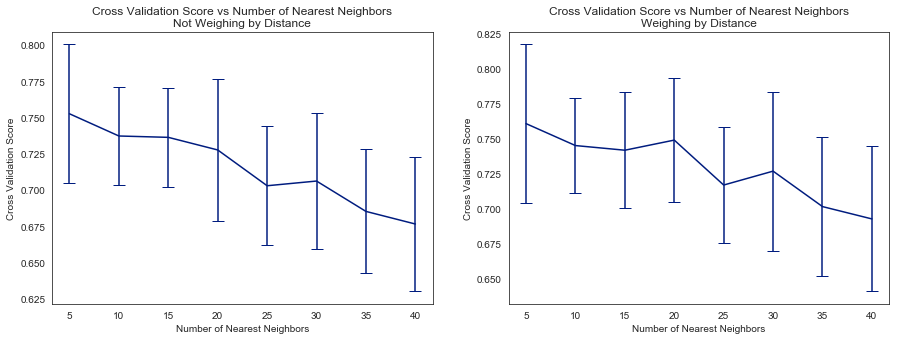

In [1222]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [5,10,15,20,25,30,35,40]
mean_scores = []
sigma2_scores = []

for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

    
# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nNot Weighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')


# weighing by distance

mean_scores = []
sigma2_scores = []
params = {'weights':'distance'}
for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value, **params)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))


plt.subplot(1, 2, 2)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nWeighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')
plt.show()



This seems to be working well. I am already getting the impression that our corpus of presidential speeches is well suited for supervized learning. We can clearly see from these plots of cross validation score versus number of neighbors that less neighbors is better. This is surely related to the fact that we only have 20 or 30 speeches per president. Using 40 nearest neighbors does not make sense. Let's try using even fewer neighbors. 

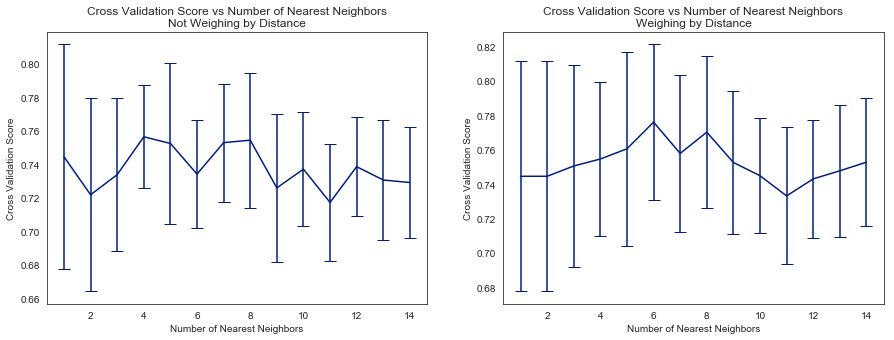

In [1224]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = list(range(1,15))
mean_scores = []
sigma2_scores = []

for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

    
# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nNot Weighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')


# weighing by distance

mean_scores = []
sigma2_scores = []
params = {'weights':'distance'}
for value in values: 
    neighbors = KNeighborsClassifier(n_neighbors=value, **params)
    cross_score = cross_val_score(neighbors, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))


plt.subplot(1, 2, 2)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Nearest Neighbors\nWeighing by Distance')
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Cross Validation Score')
plt.show()

It looks like using five to ten neighbors is best. Weighing by distance also looks to help a bit, though it is hard to say given the errorbars. Let's use what looks to be best here: weighing by distance and using 6 neighbors. We achieve a cross validation score of roughly 78%.

## Random Forest

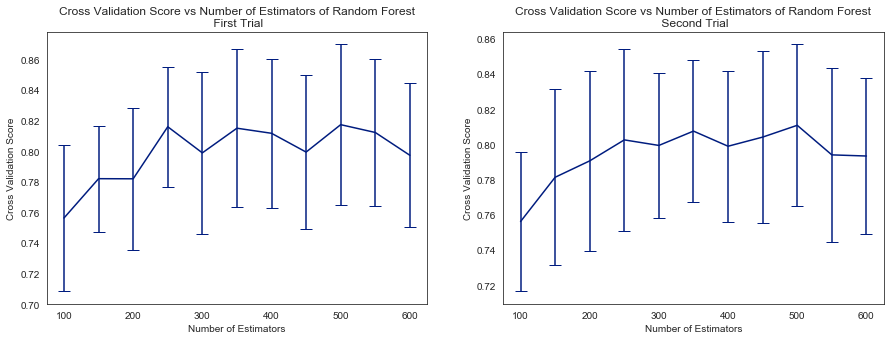

In [1230]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [100,150,200,250,300,350,400,450,500,550,600]
params = {}
mean_scores = []
sigma2_scores = []

for value in values: 
    rfc = ensemble.RandomForestClassifier(n_estimators=value, **params)
    cross_score = cross_val_score(rfc, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Estimators of Random Forest\n First Trial')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')

mean_scores = []
sigma2_scores = []

for value in values: 
    rfc = ensemble.RandomForestClassifier(n_estimators=value, **params)
    cross_score = cross_val_score(rfc, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))
    
plt.subplot(1, 2, 2)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Estimators of Random Forest\n Second Trial')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')
plt.show()

Random forest is performing even better. We are up to a cross validation score of roughly 80%. We chose to plot the cross validation scores for differing number of estimators twice to show how the random nature of the random forest leads to different peaks and valleys of these plots. Let's use 400 estimators and know we have a cross validation score of roughly 80% or 81%. 

## Logistic Regression

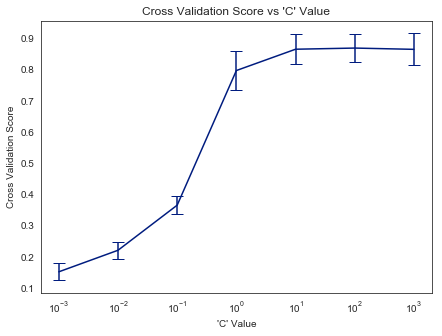

In [1238]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [.001, .01, .1, 1, 10, 100, 1000]
params = {'multi_class':'auto', 'solver':'lbfgs'}
mean_scores = []
sigma2_scores = []

for value in values: 
    lr = LogisticRegression(C=value, **params)
    cross_score = cross_val_score(lr, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

plt.figure(figsize=(7,5))
plt.xscale('log')
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs \'C\' Value')
plt.xlabel('\'C\' Value')
plt.ylabel('Cross Validation Score')
plt.show()

So long as we use a larger 'C' Logistic Regression seems to be the best model so far. Let's look at this plot again but with larger 'C' values.

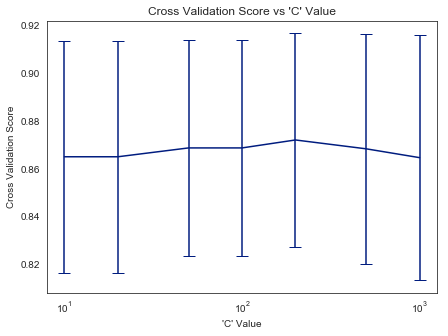

In [1239]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [10, 20, 50, 100, 200, 500, 1000]
params = {'multi_class':'auto', 'solver':'lbfgs'} # updated default parameters
mean_scores = []
sigma2_scores = []

for value in values: 
    lr = LogisticRegression(C=value, **params)
    cross_score = cross_val_score(lr, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

plt.figure(figsize=(7,5))
plt.xscale('log')
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs \'C\' Value')
plt.xlabel('\'C\' Value')
plt.ylabel('Cross Validation Score')
plt.show()

Logistic Regression is indeed our best clustering algorithm thus far. We have a mean cross validation score of roughly 87%. Let's use 200 as our 'C' value. It's average cross validation score is really no higher than the others given the errorbar, but we must pick some value for 'C'. 

## Support Vector Machine

In [1241]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
svclf = SVC(kernel='linear') # using the a linear kernel
cross_score = cross_val_score(svclf, X, y, cv=10)
print('cross validation score = '+ str(round(cross_score.mean(),6)) +' +/- ' + str(round(cross_score.std()*2/np.sqrt(len(cross_score)),6)))


cross validation score = 0.847593 +/- 0.049633


Our support vector machine has returned another good cross validation score. We have a mean score of roughly 85%. That is a very good score by not quite as high as our score for logistic regression. Our logistic regression model remains the winner. Let's finally try a gradient boosting classifier.

## Gradient Boosting Classifier

Text(0, 0.5, 'Cross Validation Score')

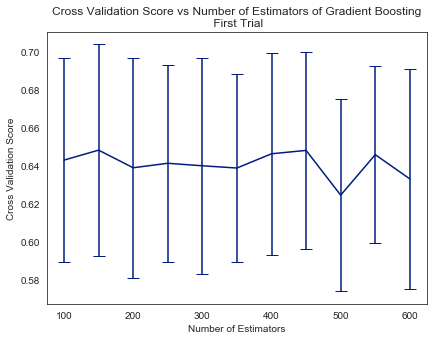

In [1246]:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
values = [100,150,200,250,300,350,400,450,500,550,600]
params = {}
mean_scores = []
sigma2_scores = []

for value in values: 
    gbc = GradientBoostingClassifier(n_estimators = value, **params)
    cross_score = cross_val_score(gbc, X, y, cv=10)
    mean_scores.append(cross_score.mean())
    sigma2_scores.append(cross_score.std() * 2 / np.sqrt(len(cross_score)))

# Plotting the two figures.    
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.errorbar(values, mean_scores, yerr = sigma2_scores, capsize=6)
plt.title('Cross Validation Score vs Number of Estimators of Gradient Boosting')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross Validation Score')
plt.show()


We see that using the gradient boosting classifier is not the optimal model for classifying speech by president. All these score are roughly 65% regardless of the number of estimators used. We have found our winner classifier.

In [1249]:
## calculating the score statistics for our winning classifier:
X = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
y = df_tfidf['president_']
params = {'multi_class':'auto', 'solver':'lbfgs'}
lr = LogisticRegression(C=200, **params)
cross_score = cross_val_score(lr, X, y, cv=10)
print('cross validation score = '+ str(round(cross_score.mean(),6)) +' +/- ' + str(round(cross_score.std()*2/np.sqrt(len(cross_score)),6)))

cross validation score = 0.872104 +/- 0.044717


## Winning Classifier

Logistic Regression with 'C' = 200, multi_class = 'auto', solver = 'lbfgs'

cross validation score = .872104 +/- 0.044717

# Using our Winning Classifier to predict our holdout data

Let's now see how well our clasifier predicts the holdout data. 

In [1310]:
# our testing and training input data
X_train = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
X_test = df_tfidf_test.drop(['text_', 'president_era_', 'president_'], 1)

# our models target to train on and testing target
y_train = df_tfidf['president_']
y_test_true = df_tfidf_test['president_']

# our winning model
params = {'multi_class':'auto', 'solver':'lbfgs'}
lr = LogisticRegression(C=200, **params)

# fitting to the training data and prediction the testing data
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

# our evaluation metrics
cf = confusion_matrix(y_test_true, y_test_pred, labels=presidents)
pd.DataFrame(cf)
print('We have achieved an accuracy score of {}%.'.format(100*round(accuracy_score(y_test_true, y_test_pred), 3)))

# formating the pandas dataframe which shows our confusion matrix
d = dict(selector="th",
    props=[('text-align', 'center')])

# printing our results
print('Our Confusion Matrix:\n(The rows are the true labels. The columns are our model\'s predictions)')
pd.DataFrame(cf, columns=presidents, index=presidents).style.set_properties(**{'width':'6em', 'text-align':'center'})\
        .set_table_styles([d])

We have achieved an accuracy score of 84.3%.
Our Confusion Matrix:
(The rows are the true labels. The columns are our model's predictions)


,obama,gwbush,clinton,kennedy,fdroosevelt,grant,johnson,jackson,jefferson,washington
obama,12,0,0,0,0,0,0,0,0,0
gwbush,0,9,0,0,1,0,0,0,0,0
clinton,1,1,7,1,0,0,0,0,0,0
kennedy,0,0,0,11,0,0,0,0,0,0
fdroosevelt,0,0,0,0,12,0,0,0,0,0
grant,0,0,0,0,0,4,3,0,1,0
johnson,0,0,0,0,0,0,8,0,0,0
jackson,0,0,0,0,0,0,0,5,2,0
jefferson,0,0,0,0,0,0,0,0,4,2
washington,0,0,0,0,0,0,0,2,0,3


## Evaluation of Classification on Hold Out Group

Our logistic regression model does a great job predicting the outcome variable. It seems our data is well-suited for classification. Our model predicted the correct class in 84.3% of instances. This is a considerably high score considering we have 10 classes. An accuracy score of 84.3% in a binary classifier is less impressive. We see from our confusion matrix that most of our predictions lie on the diagonal, meaning those instances were correctly classified. We have relatively few counts not on the diagonal. Those counts are also generally close to the diagonal, which is something we would want. It indicates that those misclassified speeches were at least predicted to be from a president who served at a time close to that of the true target president. For instance. The '1' at row='clinton', column='obama' is a speech that was given by Bill Clinton, but our model predicted it was from Obama. At least these two presidents served during similar times. It would be much more concerning of our model predicted that Andrew Jackson gave that speech. We see a similar pattern in the other misclassified speeches. 

Let's see how our model does at predicting the presidential era of the holdout instances.

In [1338]:
X_train = df_tfidf.drop(['text_', 'president_era_', 'president_'], 1)
X_test = df_tfidf_test.drop(['text_', 'president_era_', 'president_'], 1)

y_train = df_tfidf['president_era_']
y_test_true = df_tfidf_test['president_era_']

params = {'multi_class':'auto', 'solver':'lbfgs'}
lr = LogisticRegression(C=200, **params)

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

cf = confusion_matrix(y_test_true, y_test_pred, labels=['more_recent', 'less_recent'])
pd.DataFrame(cf)
print('When predicting by era, we have achieved an accuracy score of {}%.'.format(
    100*round(accuracy_score(y_test_true, y_test_pred), 3)))

d = dict(selector="th",
    props=[('text-align', 'center')])

print('Our President Era Confusion Matrix:\n(The rows are the true labels.\
The columns are our model\'s predictions)')
pd.DataFrame(cf, columns=['more_recent', 'less_recent'],
             index=['more_recent', 'less_recent']).style.set_properties(**{'width':'6em', 'text-align':'center'})\
        .set_table_styles([d])


When predicting by era, we have achieved an accuracy score of 100.0%.
Our President Era Confusion Matrix:
(The rows are the true labels.The columns are our model's predictions)


,more_recent,less_recent
more_recent,55,0
less_recent,0,34


## Evaluation of President Era Classification on Hold Out Group

Our model predicts the hold out group's president era with perfect accuracy. Of all the speeches it was not trained on, is classifies each speech correctly by era. This is not that surprizing considering how well it is classifying by president. This is a much simpler task and it performed very well on the more difficult task. 

# Conclusion and Future Thoughts

While we have tried different combinations of Bag of Words features with differing numbers of LSA components and different kinds of scaling, as well as different tf-idf features and different algorithms (e.g. k-means, mean-shift, etc.), we were not able to cluster speeches very well by president, but we were not completely unsuccessful. Our best clustering algorithm earned Adjusted Rand Index score of 0.314 +/- 0.028 when clustering our training data and 0.246 +/- 0.013 when clustering the hold out. A perfect score is 1.0 and random clustering yields a score of 0.0. We are certainly performing better than random clustering. We did, however, achieve great clustering when attempting to cluster by era (i.e. presidents who served before and after 1900). This was not our goal, but we certainly achieved it. Our best algorithm earned a near perfect ARI score of 0.986 +/- 0.003 when clustering the training data and 0.900 +/- 0.040 when clustering the hold out data. It was obvious to the eye when looking at the clusters projected onto the two primary LSA components that there were two clear clusters. Five of the presidents were in one cluster, and the other five were in the other. 

We then applied supervised learning to attemp to classify the speeches by president rather than simply clustering and that worked extremely well. Logistic Regression with a C-value of 200 was our best classifier, and it earned an accuracy score of 84% on the hold out data. With 10 classes, this is a very high accuracy score. We performed perfectly when using this classifier to predict the era of a speech. While perfect classification can be a bit concerning, with only 89 testing datapoints, this is not that unreasonable. We did not exclude any names or dates from the data. These features are highly suggestive. For instance, the feature 'Barack' is a huge give away that the speach was from Obama or the preceding president, G.W.Bush. No president in the 1800's will say, "Barack." Also '1945' will almost certainly never be said by a president from the 1800's. These kinds of features are likely responsible for our very high accuracy scores. If one were to remove all names and dates from the feature space, the problem would become much more difficult. 

It would be very interesting to use more presidents. The corpus where we downloaded the data has speeches by many more presidents. Would clustering by era become even more successful? Would we see more eras emerge from the data? Maybe three or four groups of presidents would cluster together if we used more presidents. The eras may be more well-defined, or maybe they would all blur together: with more presidents, we would have smaller gaps in time. It would also be great to have more speeches by each president. The curator of our data had done a wealth of work gathering all this data - it seems rude to want more - but having more datapoints would help facilitate our clustering. We had only 265 speeches to train on and 89 in the hold out data. There are only 21 George Washington speeches total. I suspect more distinct clusters would form if only we had more data. 

We could also try using features other than those of Bag of Words or tf-idf. Some presidents probably used sentences with more words per sentence than others. We could use spaCy's capabilities to determine parts of speech and count the number of adjectives or adverbs used per speech. We could create features related to sentence structure by analyzing the order of parts of speech per sentence. Certain presidents spoke with more repetition that others. While we have counted the term frequencies of common words, a feature devoted to finding the percentage of a speech that is the speech's most common word (excluding stop words) would be helpful. The possibilities for feature creation are endless. 

Our findings could be helpful to historians by determining the differing language used by these presidents. We could dive even deeper and search for why the presidents cluster so well into those two clusters. What is it about the document-term matrix that lends itself to use strong clustering? Will future presidents add a strong third cluster to the mix? With Donald Trumps unique way with words, this could very well be the case. 

While we have, of course, only scratched to surface of possibilities in clustering and classifying speeches by president, we have found successful ways of clustering speech by era and classifying speech by president. 

And of course, we must mention the all too straight forward and silly application of this work. If somehow, for some reason, a transcription of a U.S. presidental speech was found today with no sign of who uttered the words it bears, we could help to name it's father and certainly assist in determining it's historical era.